In [1]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as plines
import matplotlib.colors as mcolors
from IPython.display import display
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D  # for legend handle

# Specific modules
import scanpy as sc
import decoupler as dc
import anndata as ad
import scienceplots

# Setting some parameters
warnings.filterwarnings("ignore")

# Import functions
sys.path.insert(1, str(here('bin')))
from customPalette import *
from customPythonFunctions import mean_by_category, filter_low_represented_cell_group, RelativeDiff_mean_by_category, mscatter, aggregating_features,generateID2SymbolDF

plt.style.use(['nature'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

overwriteFigures = True
overwriteData = True

pd.options.display.max_columns = 300
pd.options.display.max_rows = 1000

In [2]:
print("Main directory path: {}".format(here())) 

Main directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas


**Load data**

In [3]:
inputfile_path = here("03_downstream_analysis/02_gene_universe_definition/results/04_MAIN_geneUniverse.log1p.h5ad")
# Loading scanpy (Anndata) object
adata = sc.read_h5ad(inputfile_path)
adata

AnnData object with n_obs × n_vars = 4435922 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'highly_variable'
    uns: 'log1p'

In [4]:
# Subsetting CELLTYPE & STUDY & DISEASES
adata = adata[
    (adata.obs['Level1'] == "T_CD8_NonNaive") & 
    (adata.obs['studyID'] == "SCGT00") & 
    (adata.obs['disease'] != "SLE")
]

adata.obs['disease'] = pd.Categorical(adata.obs['disease'], categories=["RA", "PS", "PSA", "CD", "UC", "healthy"], ordered=True)

In [5]:
adata.obs

studyID    libraryID  \
cellID                                                            
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA      SCGT00  SCGT00_L051   
SCGT00_L051_I55.3P_T0_AAACCCATCCCAATAG      SCGT00  SCGT00_L051   
SCGT00_L051_I52.3P_T0_AAACGAAAGGCTAACG      SCGT00  SCGT00_L051   
SCGT00_L051_I55.3P_T0_AAACGAAAGGTCCAGA      SCGT00  SCGT00_L051   
SCGT00_L051_I52.3P_T0_AAACGAAAGGTCTGGA      SCGT00  SCGT00_L051   
...                                            ...          ...   
SCGT00_L024_I018016.3P_T0_TTTCGATCACTCGATA  SCGT00  SCGT00_L024   
SCGT00_L024_I018014.3P_T0_TTTCGATGTTAAACAG  SCGT00  SCGT00_L024   
SCGT00_L024_I018012.3P_T0_TTTGACTAGAACTGAT  SCGT00  SCGT00_L024   
SCGT00_L024_I018015.3P_T0_TTTGGAGGTGTTACAC  SCGT00  SCGT00_L024   
SCGT00_L024_I0185.3P_T0_TTTGTTGAGTAGTCTC    SCGT00  SCGT00_L024   

                                                        sampleID chemistry  \
cellID                                                                       
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA          SCGT00_I57.3P_T0  3_GEX_V3   
SCGT00_L051_I55.3P_T0_AAACCCATCCCAATAG          SCGT00_I55.3P_T0  3_GEX_V3   
SCGT00_L051_I52.3P_T0_AAACGAAAGGCTAACG          SCGT00_I52.3P_T0  3_GEX_V3   
SCGT00_L051_I55.3P_T0_AAACGAAAGGTCCAGA          SCGT00_I55.3P_T0  3_GEX_V3   
SCGT00_L051_I52.3P_T0_AAACGAAAGGTCTGGA          SCGT00_I52.3P_T0  3_GEX_V3   
...                                                          ...       ...   
SCGT00_L024_I018016.3P_T0_TTTCGATCACTCGATA  SCGT00_I018016.3P_T0  3_GEX_V3   
SCGT00_L024_I018014.3P_T0_TTTCGATGTTAAACAG  SCGT00_I018014.3P_T0  3_GEX_V3   
SCGT00_L024_I018012.3P_T0_TTTGACTAGAACTGAT  SCGT00_I018012.3P_T0  3_GEX_V3   
SCGT00_L024_I018015.3P_T0_TTTGGAGGTGTTACAC  SCGT00_I018015.3P_T0  3_GEX_V3   
SCGT00_L024_I0185.3P_T0_TTTGTTGAGTAGTCTC      SCGT00_I0185.3P_T0  3_GEX_V3   

                                           disease     sex binned_age  \
cellID                                                                  
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA          RA  female      41-50   
SCGT00_L051_I55.3P_T0_AAACCCATCCCAATAG          RA  female      51-60   
SCGT00_L051_I52.3P_T0_AAACGAAAGGCTAACG          RA  female      31-40   
SCGT00_L051_I55.3P_T0_AAACGAAAGGTCCAGA          RA  female      51-60   
SCGT00_L051_I52.3P_T0_AAACGAAAGGTCTGGA          RA  female      31-40   
...                                            ...     ...        ...   
SCGT00_L024_I018016.3P_T0_TTTCGATCACTCGATA      PS    male      18-30   
SCGT00_L024_I018014.3P_T0_TTTCGATGTTAAACAG      PS    male      41-50   
SCGT00_L024_I018012.3P_T0_TTTGACTAGAACTGAT      PS  female      51-60   
SCGT00_L024_I018015.3P_T0_TTTGGAGGTGTTACAC      PS  female      51-60   
SCGT00_L024_I0185.3P_T0_TTTGTTGAGTAGTCTC        PS    male      51-60   

                                                    Level1  \
cellID                                                       
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA      T_CD8_NonNaive   
SCGT00_L051_I55.3P_T0_AAACCCATCCCAATAG      T_CD8_NonNaive   
SCGT00_L051_I52.3P_T0_AAACGAAAGGCTAACG      T_CD8_NonNaive   
SCGT00_L051_I55.3P_T0_AAACGAAAGGTCCAGA      T_CD8_NonNaive   
SCGT00_L051_I52.3P_T0_AAACGAAAGGTCTGGA      T_CD8_NonNaive   
...                                                    ...   
SCGT00_L024_I018016.3P_T0_TTTCGATCACTCGATA  T_CD8_NonNaive   
SCGT00_L024_I018014.3P_T0_TTTCGATGTTAAACAG  T_CD8_NonNaive   
SCGT00_L024_I018012.3P_T0_TTTGACTAGAACTGAT  T_CD8_NonNaive   
SCGT00_L024_I018015.3P_T0_TTTGGAGGTGTTACAC  T_CD8_NonNaive   
SCGT00_L024_I0185.3P_T0_TTTGTTGAGTAGTCTC    T_CD8_NonNaive   

                                                         Level2  
cellID                                                           
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA          T_CD8_eff_HOBIT  
SCGT00_L051_I55.3P_T0_AAACCCATCCCAATAG          T_CD8_activated  
SCGT00_L051_I52.3P_T0_AAACGAAAGGCTAACG                 T_CD8_CM  
SCGT00_L051_I55.3P_T0_AAACGAAAGGTCCAGA      T_CD8_Mem_cytotoxic  
SCG

**Load Clinical Metadata**

In [6]:
adata_met = pd.read_pickle(here(f"00_data_processing/results/extended_obs/SCGT00_obs.pkl")) 

adata_met = adata_met[(adata_met['disease'] != "SLE")]
adata_met.head()

index  \
cellID                                                                         
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA  zsggoqfp_x3zbi5sd_AAACCCAAGGTGAGAA-1   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG  zsggoqfp_x3zbi5sd_AAACCCAAGTCCGTCG-1   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT  zsggoqfp_x3zbi5sd_AAACCCAAGTGCACTT-1   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT  zsggoqfp_x3zbi5sd_AAACCCACAACTGTGT-1   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT  zsggoqfp_x3zbi5sd_AAACCCACAAGAATGT-1   

                                               orig.ident nCount_RNA  \
cellID                                                                 
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA  zsggoqfp_x3zbi5sd      706.0   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG  zsggoqfp_x3zbi5sd     3807.0   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT  zsggoqfp_x3zbi5sd     9847.0   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT  zsggoqfp_x3zbi5sd     1100.0   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT  zsggoqfp_x3zbi5sd     4115.0   

                                       nFeature_RNA             gem_id  \
cellID                                                                   
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA          406  zsggoqfp_x3zbi5sd   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG         1094  zsggoqfp_x3zbi5sd   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT         2508  zsggoqfp_x3zbi5sd   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT          605  zsggoqfp_x3zbi5sd   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT          989  zsggoqfp_x3zbi5sd   

                                       scrublet_doublet_scores  \
cellID                                                           
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA                   0.092   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG                   0.104   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT                    0.09   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT                    0.01   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT                   0.086   

                                       scrublet_predicted_doublet  \
cellID                                                              
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA                      False   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG                      False   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT                      False   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT                      False   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT                      False   

                                              library_name INFL_chemistry  \
cellID                                                                      
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA  Pool1_IL6_wk0_v3_1       3_GEX_V3   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG  Pool1_IL6_wk0_v3_1       3_GEX_V3   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT  Pool1_IL6_wk0_v3_1       3_GEX_V3   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT  Pool1_IL6_wk0_v3_1       3_GEX_V3   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT  Pool1_IL6_wk0_v3_1       3_GEX_V3   

                                              batches disease  therapy  \
cellID                                                                   
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA  RA_Pool1Pool3      RA  antiIL6   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG  RA_Pool1Pool3      RA  antiIL6   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT  RA_Pool1Pool3      RA  antiIL6   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT  RA_Pool1Pool3      RA  antiIL6   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT  RA_Pool1Pool3      RA  antiIL6   

                                       demux_donor  \
cellID                                               
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA  I005-00007   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG  I005-00006   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT  I005-00003   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT  I005-00002   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT  I005-00006   

                                       sample.ID.basalWeek.scRNASeq  \
cellID                        

In [7]:
adata.obs = pd.merge(adata.obs, adata_met["Response"], left_index=True, right_index=True)
adata.obs.rename(columns={"Response": "therapyResponse"}, inplace=True)
adata.obs.head()

studyID    libraryID          sampleID  \
cellID                                                                          
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA  SCGT00  SCGT00_L051  SCGT00_I57.3P_T0   
SCGT00_L051_I55.3P_T0_AAACCCATCCCAATAG  SCGT00  SCGT00_L051  SCGT00_I55.3P_T0   
SCGT00_L051_I52.3P_T0_AAACGAAAGGCTAACG  SCGT00  SCGT00_L051  SCGT00_I52.3P_T0   
SCGT00_L051_I55.3P_T0_AAACGAAAGGTCCAGA  SCGT00  SCGT00_L051  SCGT00_I55.3P_T0   
SCGT00_L051_I52.3P_T0_AAACGAAAGGTCTGGA  SCGT00  SCGT00_L051  SCGT00_I52.3P_T0   

                                       chemistry disease     sex binned_age  \
cellID                                                                        
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA  3_GEX_V3      RA  female      41-50   
SCGT00_L051_I55.3P_T0_AAACCCATCCCAATAG  3_GEX_V3      RA  female      51-60   
SCGT00_L051_I52.3P_T0_AAACGAAAGGCTAACG  3_GEX_V3      RA  female      31-40   
SCGT00_L051_I55.3P_T0_AAACGAAAGGTCCAGA  3_GEX_V3      RA  female      51-60   
SCGT00_L051_I52.3P_T0_AAACGAAAGGTCTGGA  3_GEX_V3      RA  female      31-40   

                                                Level1               Level2  \
cellID                                                                        
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA  T_CD8_NonNaive      T_CD8_eff_HOBIT   
SCGT00_L051_I55.3P_T0_AAACCCATCCCAATAG  T_CD8_NonNaive      T_CD8_activated   
SCGT00_L051_I52.3P_T0_AAACGAAAGGCTAACG  T_CD8_NonNaive             T_CD8_CM   
SCGT00_L051_I55.3P_T0_AAACGAAAGGTCCAGA  T_CD8_NonNaive  T_CD8_Mem_cytotoxic   
SCGT00_L051_I52.3P_T0_AAACGAAAGGTCTGGA  T_CD8_NonNaive    T_CD8_IFNresponse   

                                       therapyResponse  
cellID                                                  
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA              NR  
SCGT00_L051_I55.3P_T0_AAACCCATCCCAATAG               R  
SCGT00_L051_I52.3P_T0_AAACGAAAGGCTAACG              NR  
SCGT00_L051_I55.3P_T0_AAACGAAAGGTCCAGA               R  
SCGT00_L051_I52.3P_T0_AAACGAAAGGTCTGGA              NR

**Generate new variables**

In [8]:
varDF = pd.read_csv(here('03_downstream_analysis/05_SPECTRA/results/varDF.csv'), index_col=0)
varDF

hgnc_id           symbol     locus_group   HUGO_status  \
ensembl_gene_id                                                              
ENSG00000000003  HGNC:11858           TSPAN6  protein_coding      official   
ENSG00000000419   HGNC:3005             DPM1  protein_coding      official   
ENSG00000000457  HGNC:19285            SCYL3  protein_coding      official   
ENSG00000000460  HGNC:25565            FIRRM  protein_coding      official   
ENSG00000000938   HGNC:3697              FGR  protein_coding      official   
...                     ...              ...             ...           ...   
ENSG00000288253         NaN  ENSG00000288253          lncRNA  non-official   
ENSG00000288302         NaN     LOC124903386          lncRNA  non-official   
ENSG00000288398         NaN  ENSG00000288398          lncRNA  non-official   
ENSG00000288558  HGNC:54422     DUS4L-BCAP29           other      official   
ENSG00000288596  HGNC:25646          C8orf44           other      official   

                    mt   ribo     hb    plt  
ensembl_gene_id                              
ENSG00000000003  False  False  False  False  
ENSG00000000419  False  False  False  False  
ENSG00000000457  False  False  False  False  
ENSG00000000460  False  False  False  False  
ENSG00000000938  False  False  False  False  
...                ...    ...    ...    ...  
ENSG00000288253  False  False  False  False  
ENSG00000288302  False  False  False  False  
ENSG00000288398  False  False  False  False  
ENSG00000288558  False  False  False  False  
ENSG00000288596  False  False  False  False  

[22838 rows x 8 columns]

In [9]:
geneSetFactors = pd.read_csv(here('03_downstream_analysis/05_SPECTRA/results/SPECTRAFactor_Renamed_Processed_LAM0.001_S0.6_markersDF.csv'), 
                          index_col=0)
TCD8NonNaive_IFNT12L_ENSBL = geneSetFactors[geneSetFactors['109-X-T_CD8_NonNaive-X-IFN_Type_1_2_Lambda']].index.to_list()
TCD8NonNaive_IFNT12L_ENSBL

['ENSG00000007264',
 'ENSG00000011600',
 'ENSG00000027697',
 'ENSG00000036448',
 'ENSG00000069702',
 'ENSG00000075234',
 'ENSG00000100097',
 'ENSG00000100321',
 'ENSG00000100453',
 'ENSG00000101474',
 'ENSG00000109861',
 'ENSG00000111537',
 'ENSG00000116171',
 'ENSG00000116667',
 'ENSG00000127314',
 'ENSG00000131018',
 'ENSG00000134539',
 'ENSG00000135404',
 'ENSG00000135441',
 'ENSG00000136156',
 'ENSG00000137441',
 'ENSG00000138378',
 'ENSG00000142166',
 'ENSG00000145287',
 'ENSG00000147443',
 'ENSG00000150045',
 'ENSG00000150687',
 'ENSG00000155368',
 'ENSG00000159110',
 'ENSG00000159674',
 'ENSG00000164483',
 'ENSG00000164674',
 'ENSG00000167618',
 'ENSG00000169554',
 'ENSG00000169583',
 'ENSG00000171476',
 'ENSG00000172531',
 'ENSG00000175567',
 'ENSG00000176083',
 'ENSG00000177047',
 'ENSG00000182393',
 'ENSG00000185436',
 'ENSG00000189067',
 'ENSG00000196154',
 'ENSG00000205810',
 'ENSG00000213145',
 'ENSG00000229474',
 'ENSG00000235162',
 'ENSG00000239713',
 'ENSG00000243772']

In [10]:
geneWeights = pd.read_csv(here('03_downstream_analysis/05_SPECTRA/results/SPECTRAFactor_Renamed_Processed_LAM0.001_S0.6_GeneWeights.csv'), 
                          index_col='Unnamed: 0')
TCD8NonNaive_IFNT12L_ENSBL_GW = geneWeights.loc['109-X-T_CD8_NonNaive-X-IFN_Type_1_2_Lambda']
TCD8NonNaive_IFNT12L_ENSBL_GW = TCD8NonNaive_IFNT12L_ENSBL_GW.loc[TCD8NonNaive_IFNT12L_ENSBL]
TCD8NonNaive_IFNT12L_ENSBL_GW = TCD8NonNaive_IFNT12L_ENSBL_GW.sort_values(ascending=False)
TCD8NonNaive_IFNT12L_ENSBL = TCD8NonNaive_IFNT12L_ENSBL_GW.index.to_list()

In [11]:
len(TCD8NonNaive_IFNT12L_ENSBL)

50

In [12]:
TCD8NonNaive_IFNT12L_genes = varDF.loc[TCD8NonNaive_IFNT12L_ENSBL, 'symbol'].tolist()
len(TCD8NonNaive_IFNT12L_genes)

50

In [13]:
TCD8NonNaive_IFNT12L_genes[:10]

['FGFBP2',
 'KLRF1',
 'IFNG',
 'PRSS23',
 'GZMB',
 'SPON2',
 'TTC38',
 'KLRD1',
 'LAIR2',
 'ZNF683']

## Explore FACTOR genes

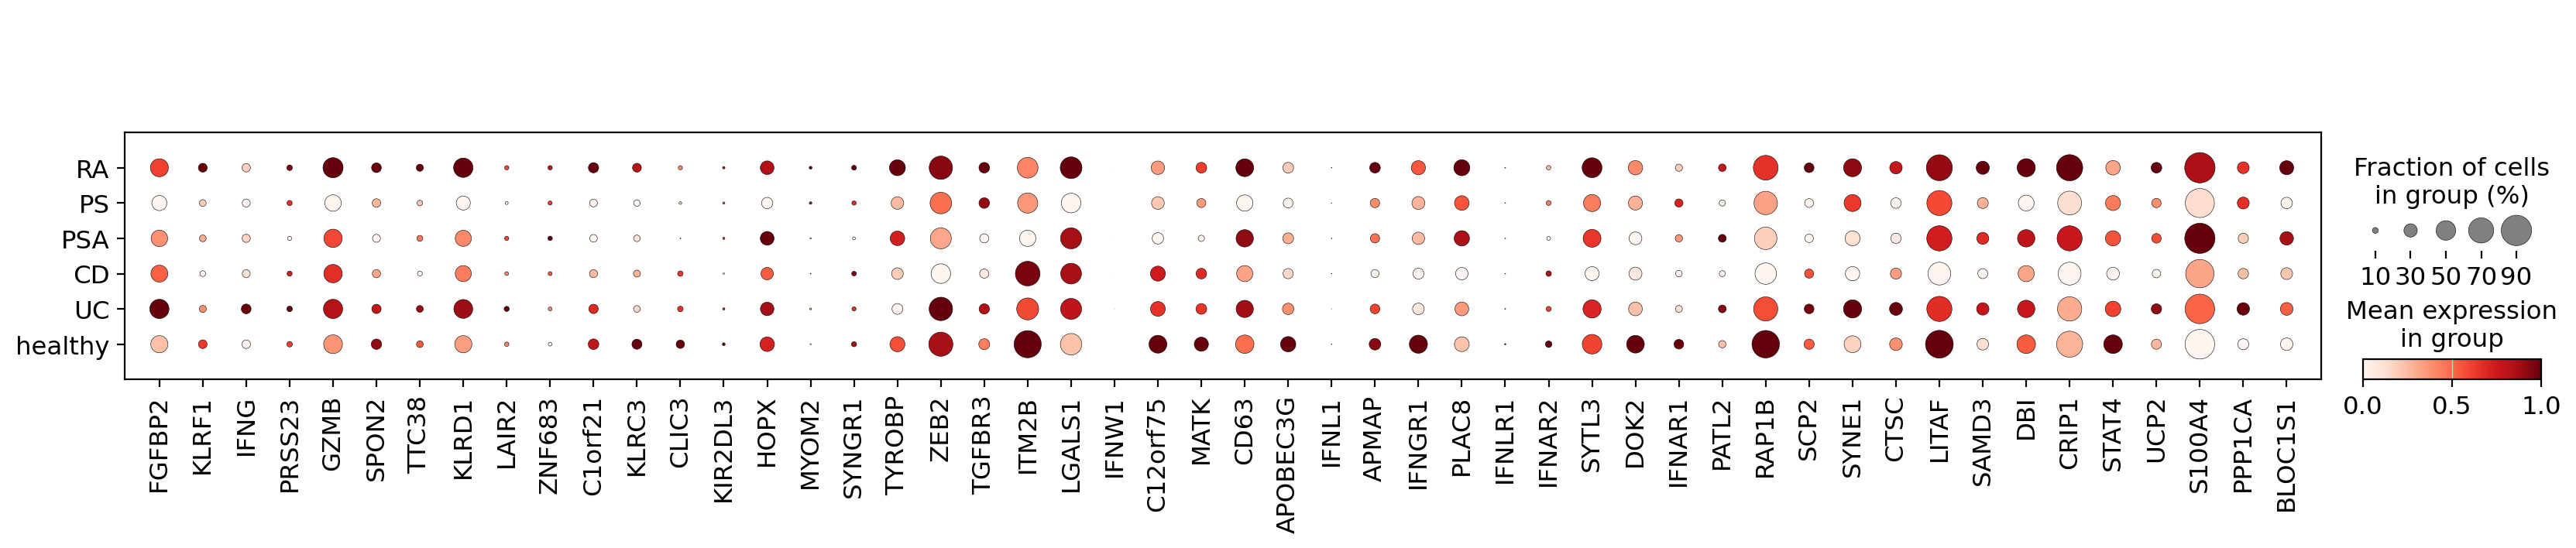

In [14]:
# Dotplot
dotplot = sc.pl.dotplot(adata, var_names = TCD8NonNaive_IFNT12L_ENSBL, groupby="disease", standard_scale='var',
                    use_raw = False, dendrogram=False, show=False, return_fig=True)

#dotplot.add_totals()
dotplot.get_axes()['mainplot_ax'].set_xticklabels(TCD8NonNaive_IFNT12L_genes)
plt.savefig(here(f'03_downstream_analysis/06_inflammation_signatures/results/figures/GeneExp_UnCorr_IFNT12L_TCD8NonNaive_L1.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

T_CD8_CM
T_CD8_CM_stem
T_CD8_EM_CX3CR1high
T_CD8_EM_CX3CR1int
T_CD8_eff_HOBIT
T_CD8_IFNresponse
T_CD8_Mem_cytotoxic
T_CD8_activated


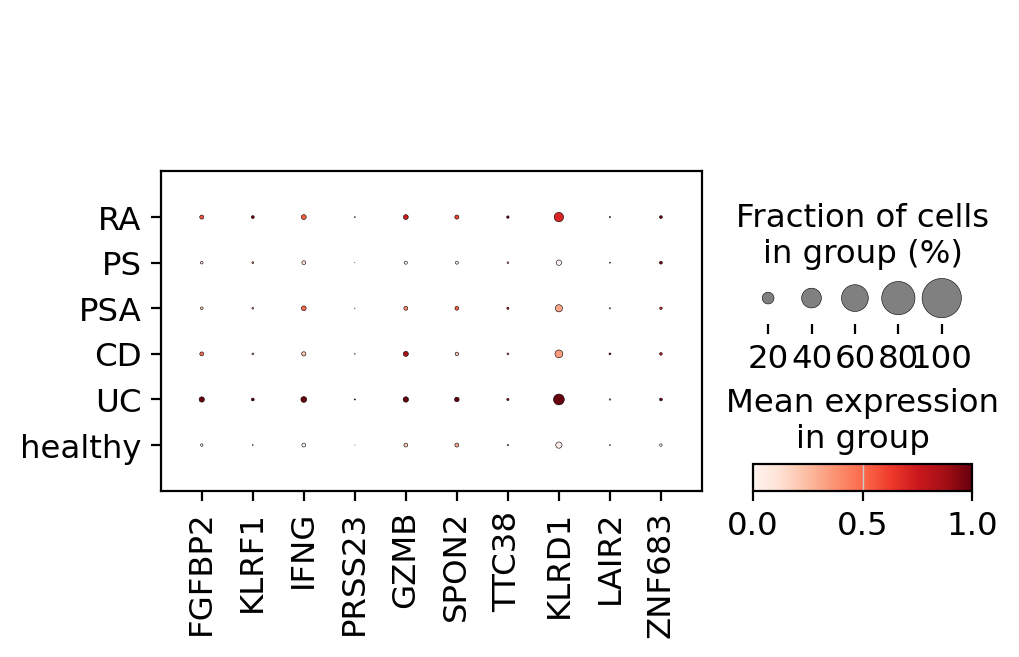

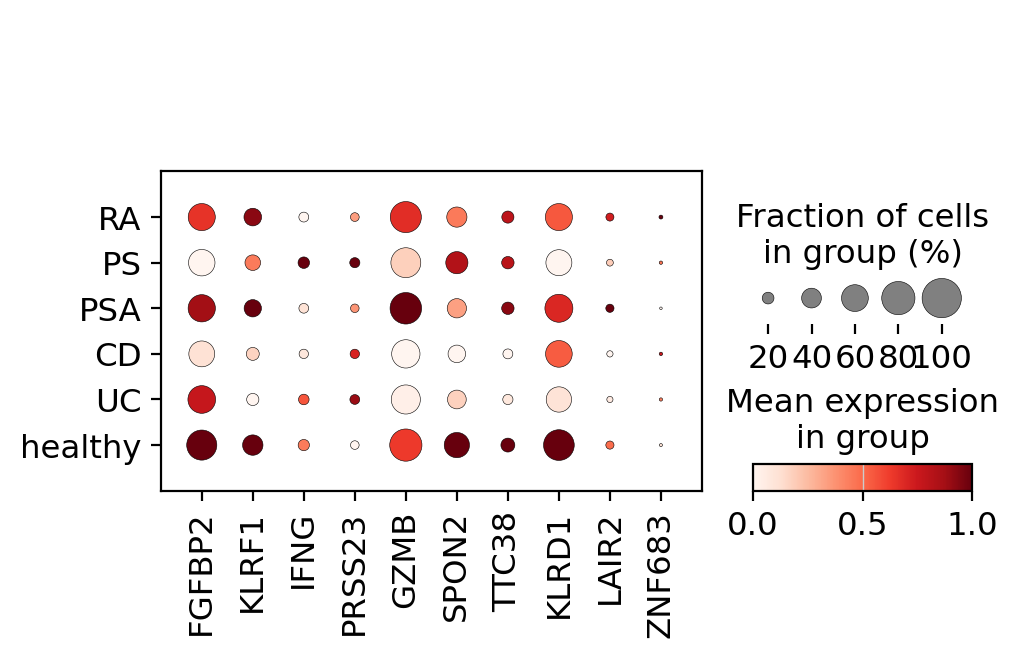

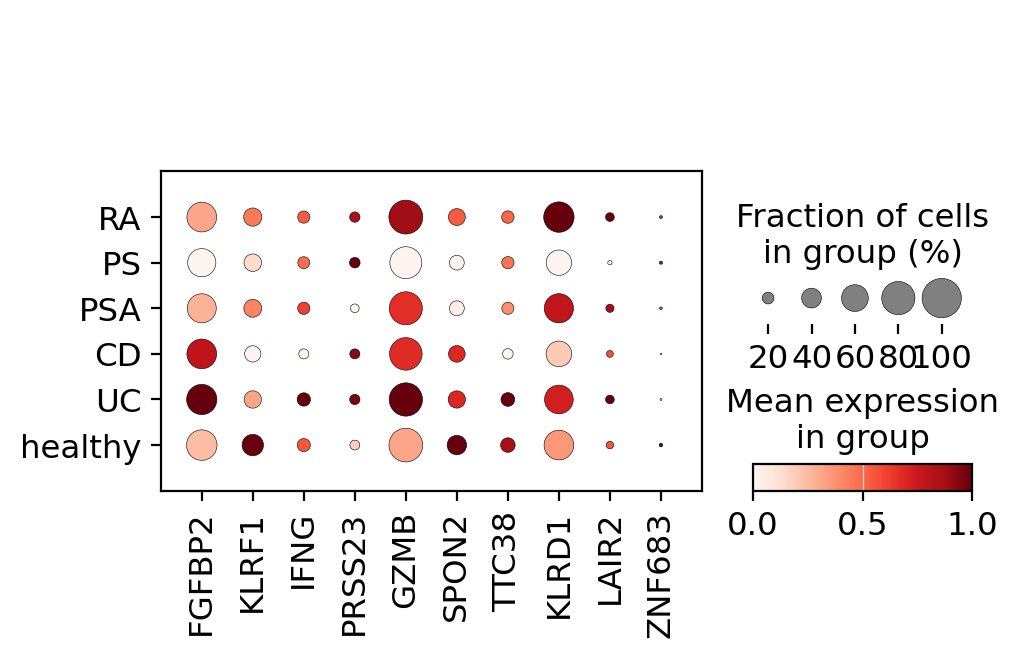

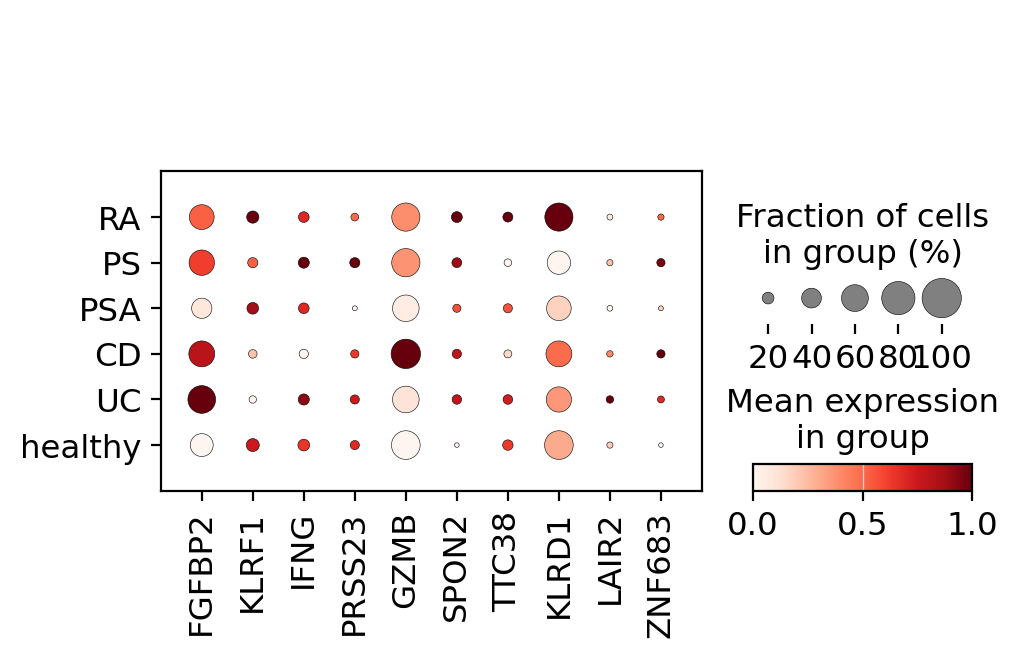

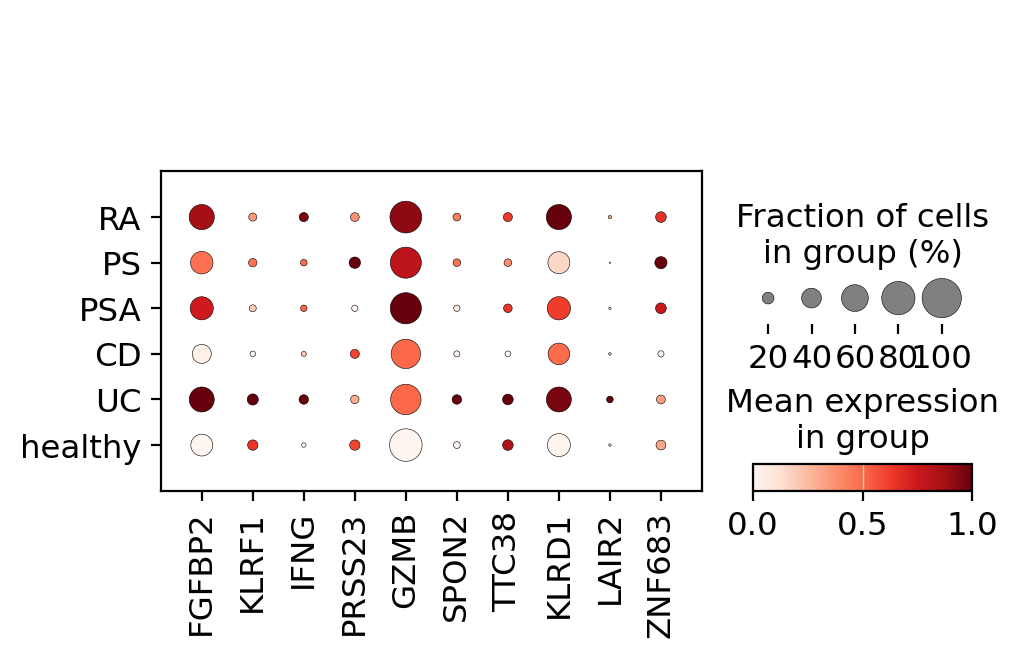

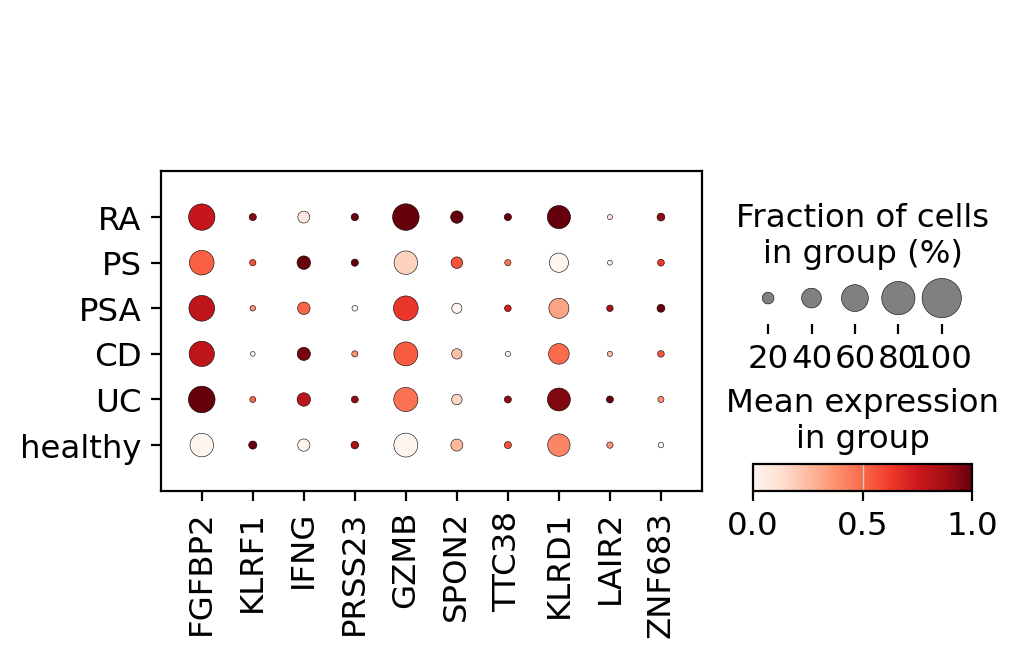

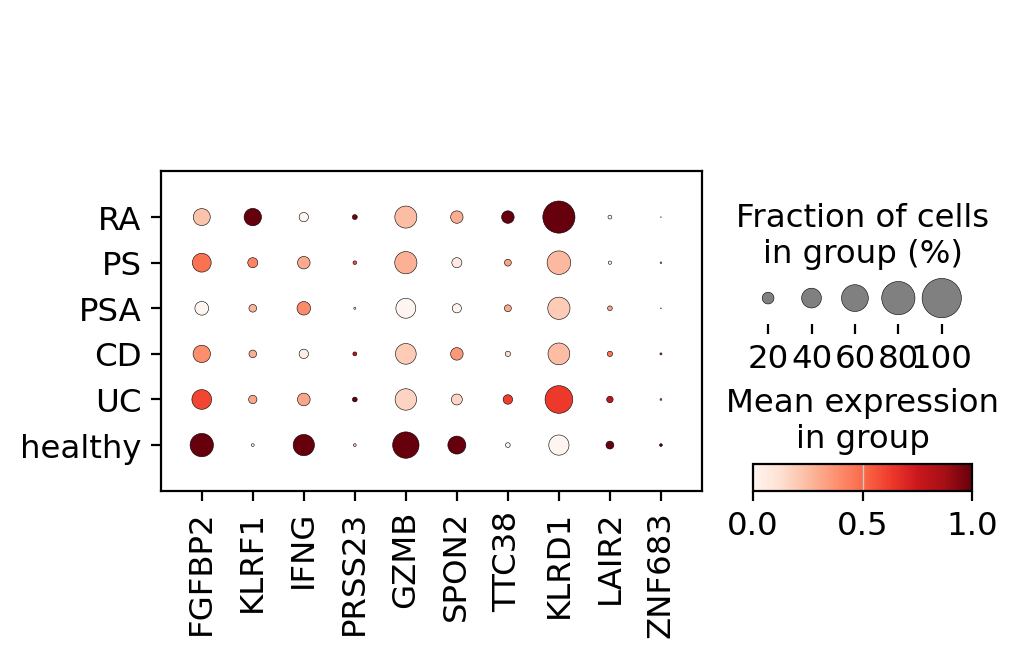

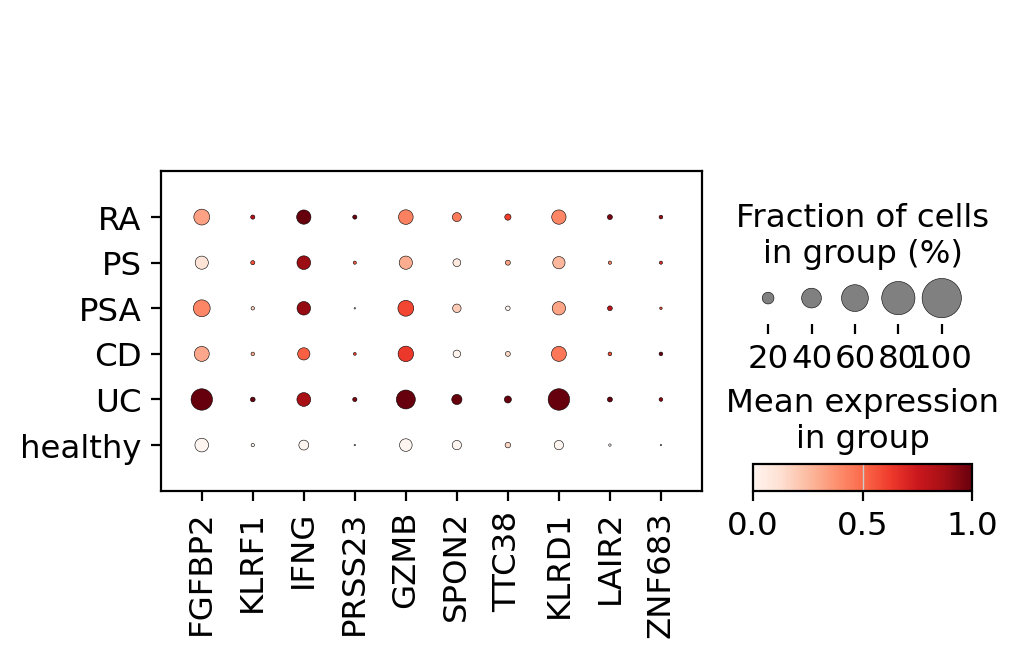

In [15]:
for cell_level2 in ["T_CD8_CM", "T_CD8_CM_stem","T_CD8_EM_CX3CR1high", "T_CD8_EM_CX3CR1int", "T_CD8_eff_HOBIT", "T_CD8_IFNresponse",  "T_CD8_Mem_cytotoxic", "T_CD8_activated"]:
    print(cell_level2)
    adata_sub = adata[adata.obs['Level2'] == cell_level2]
    
    # Dotplot
    dotplot = sc.pl.dotplot(adata_sub, var_names = TCD8NonNaive_IFNT12L_ENSBL[:10], groupby="disease", standard_scale='var',
                        use_raw = False, dendrogram=False, show=False, return_fig=True, dot_min = 0, dot_max=1)
    
    #dotplot.add_totals()
    dotplot.get_axes()['mainplot_ax'].set_xticklabels(TCD8NonNaive_IFNT12L_genes[:10])
    plt.savefig(here(f'03_downstream_analysis/06_inflammation_signatures/results/figures/GeneExp_UnCorr_IFNT12L_TCD8NonNaive_L2_{cell_level2}.svg'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

T_CD8_CM
T_CD8_CM_stem
T_CD8_EM_CX3CR1high
T_CD8_EM_CX3CR1int
T_CD8_eff_HOBIT
T_CD8_IFNresponse
T_CD8_Mem_cytotoxic
T_CD8_activated


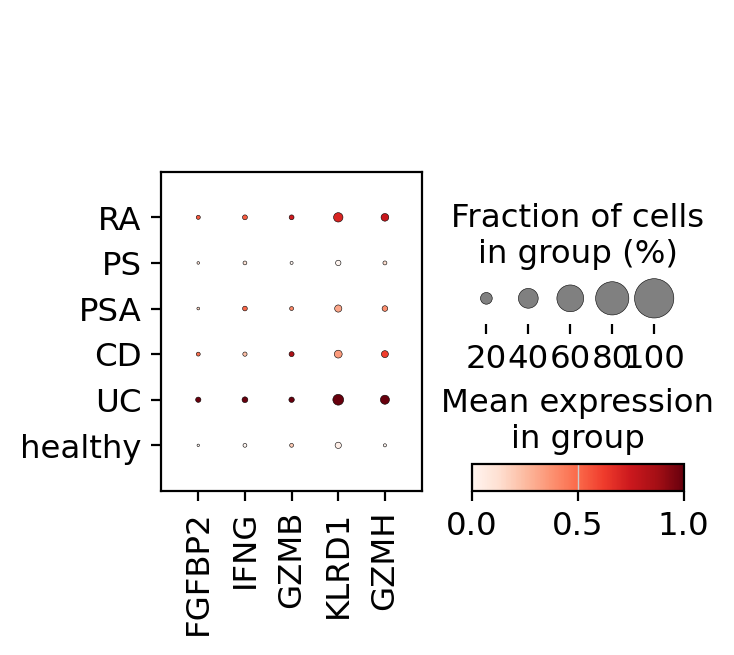

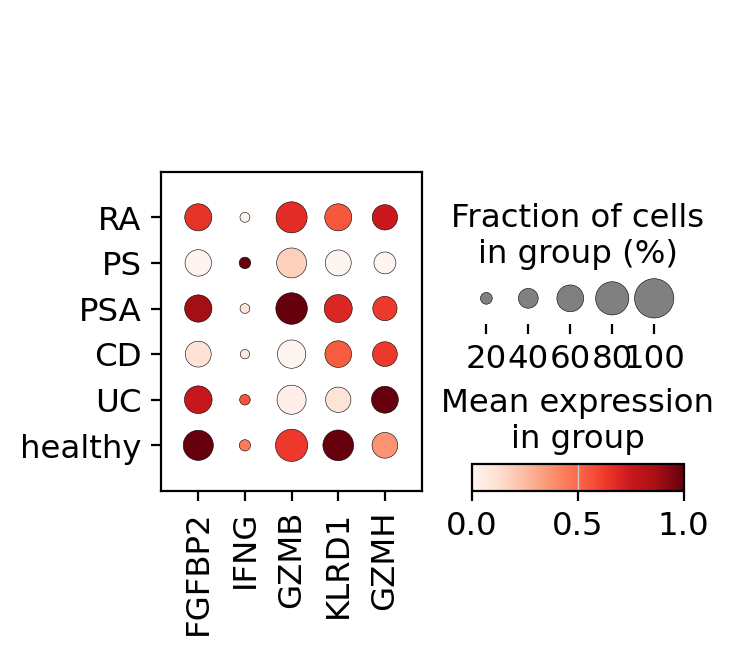

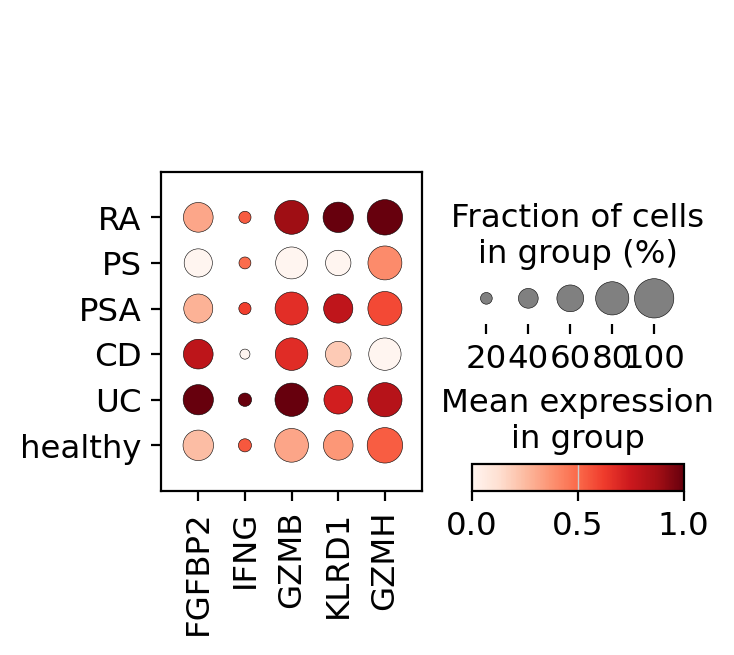

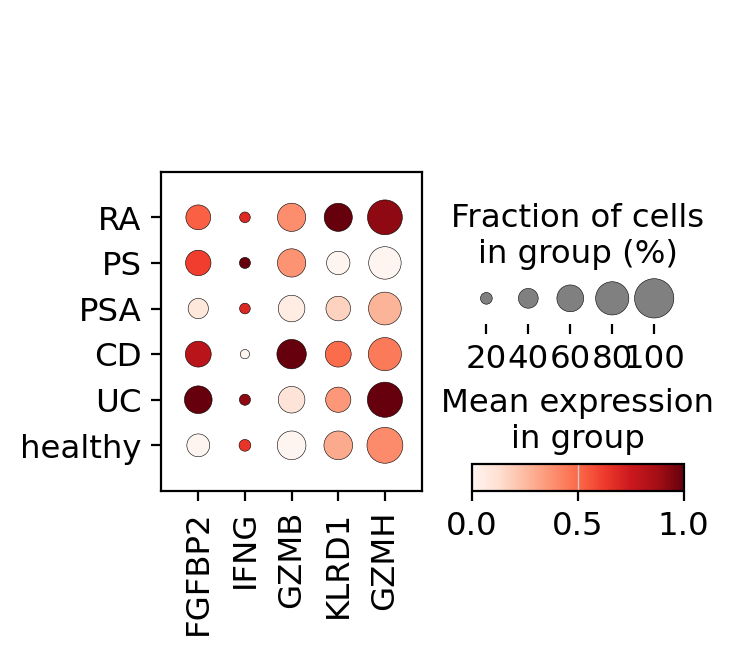

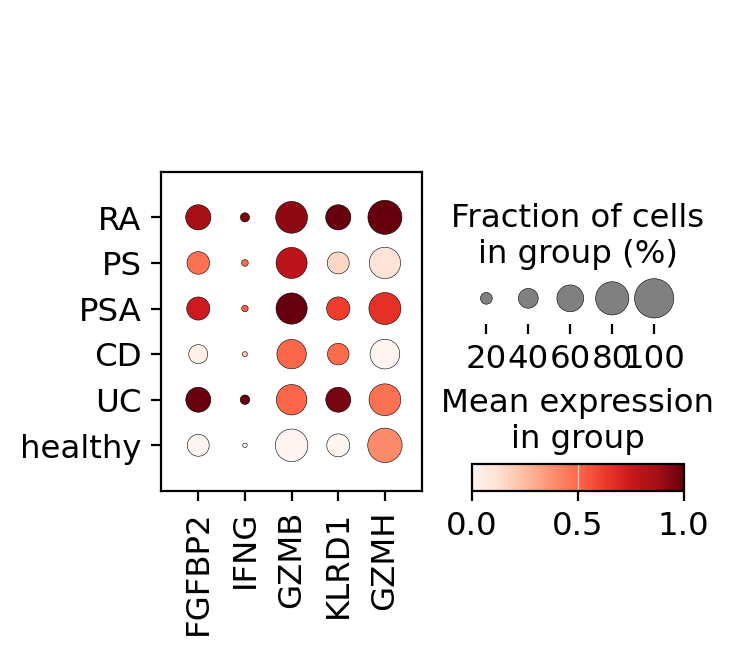

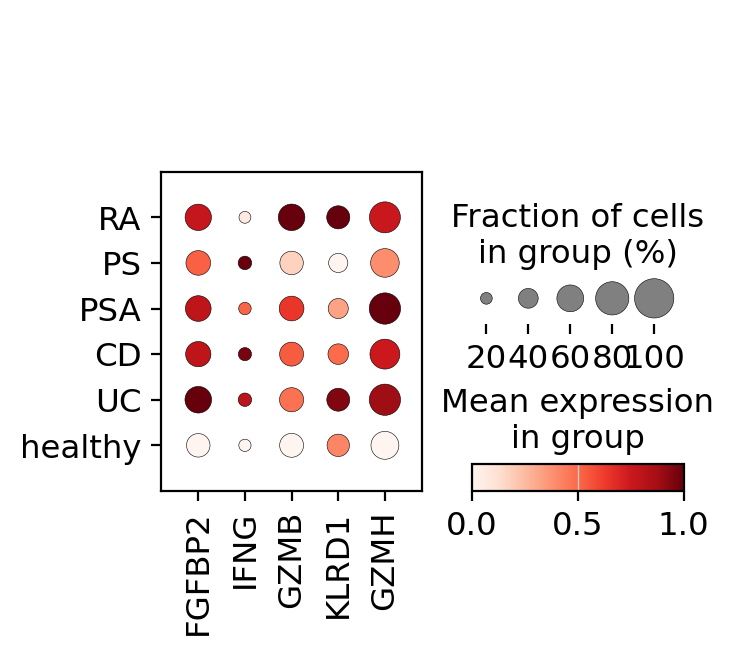

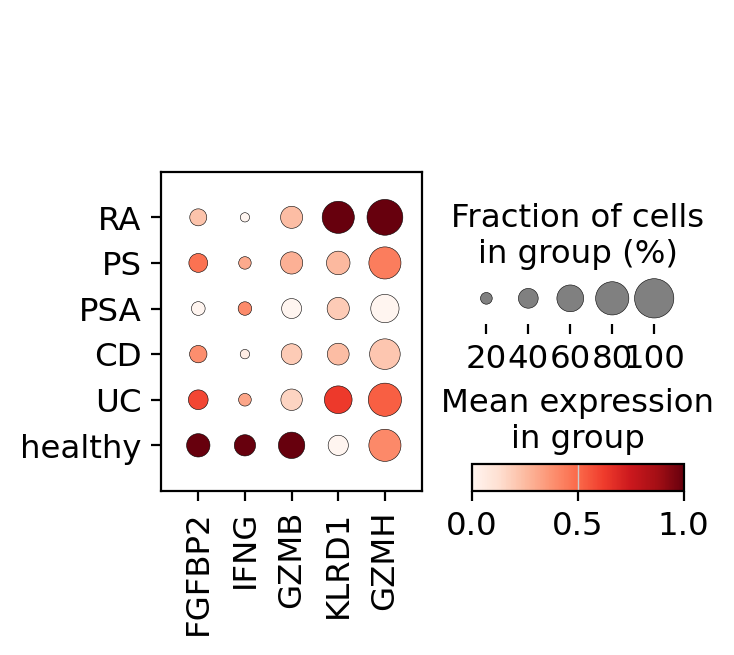

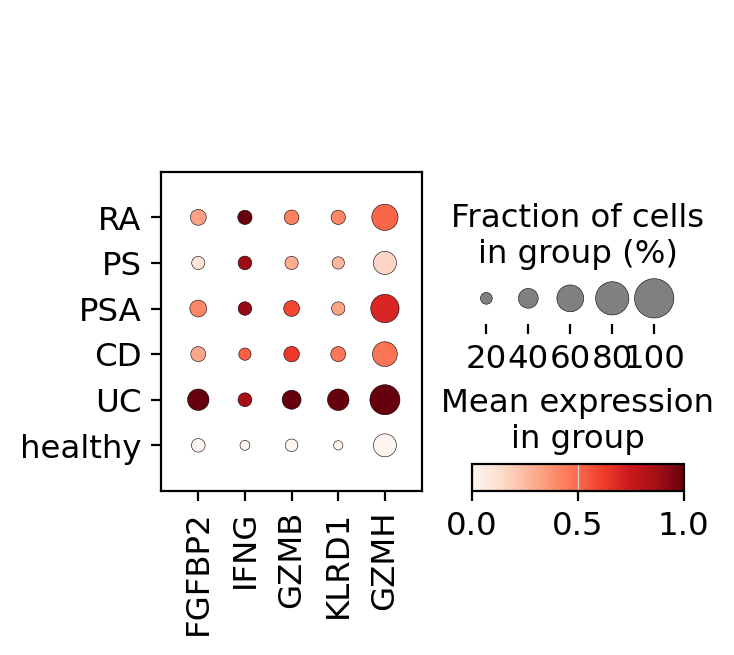

In [16]:
# For specific cells & genes
genes = ["FGFBP2", "IFNG", "GZMB", "KLRD1", "GZMH"]
genes_ENSB = generateID2SymbolDF(varDF = varDF, symbolList = genes, ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'official')["gene_id"]

for cell_level2 in ["T_CD8_CM", "T_CD8_CM_stem","T_CD8_EM_CX3CR1high", "T_CD8_EM_CX3CR1int", "T_CD8_eff_HOBIT", "T_CD8_IFNresponse",  "T_CD8_Mem_cytotoxic", "T_CD8_activated"]:
    print(cell_level2)
    adata_sub = adata[adata.obs['Level2'] == cell_level2]
    
    # Dotplot
    dotplot = sc.pl.dotplot(adata_sub, var_names = genes_ENSB, groupby="disease", standard_scale='var', use_raw = False, dendrogram=False, show=False, return_fig=True, dot_min = 0, dot_max=1)
    dotplot.get_axes()['mainplot_ax'].set_xticklabels(genes)

## Explore specific factor GENES

T_CD8_EM_CX3CR1high
T_CD8_EM_CX3CR1int
T_CD8_eff_HOBIT
T_CD8_activated


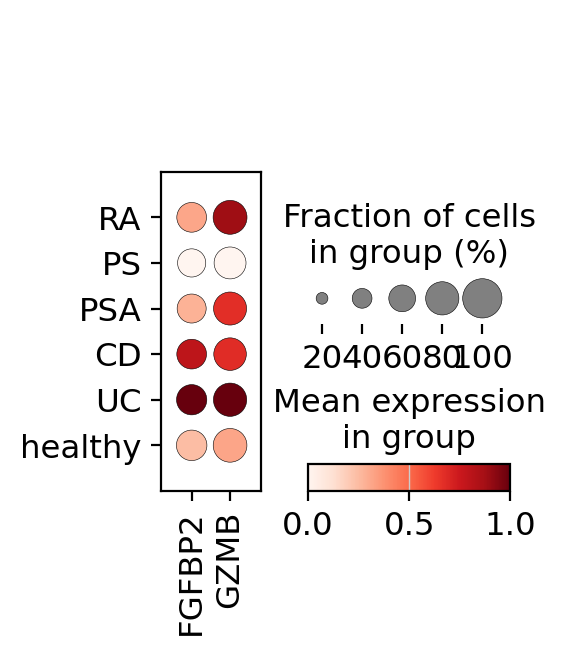

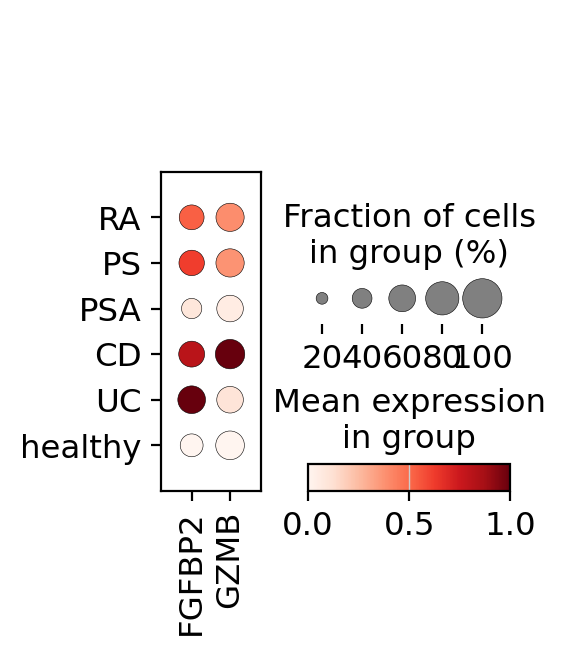

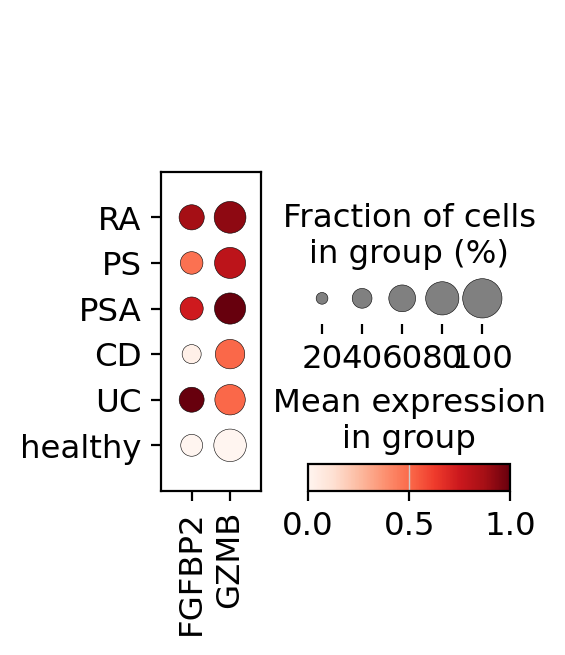

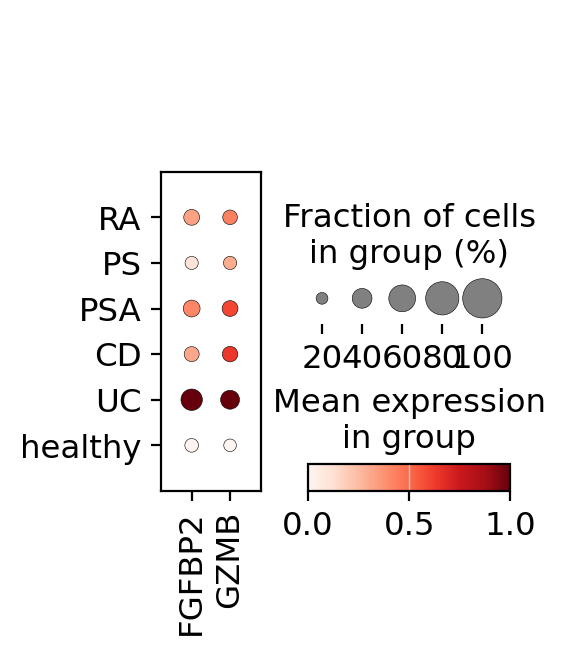

In [21]:
# For specific cells & genes
genes = ["FGFBP2", "GZMB"]
genes_ENSB = generateID2SymbolDF(varDF = varDF, symbolList = genes, ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'official')["gene_id"]

for cell_level2 in ["T_CD8_EM_CX3CR1high", "T_CD8_EM_CX3CR1int", "T_CD8_eff_HOBIT", "T_CD8_activated"]:
    print(cell_level2)
    adata_sub = adata[adata.obs['Level2'] == cell_level2]
    
    # Dotplot
    dotplot = sc.pl.dotplot(adata_sub, var_names = genes_ENSB, groupby="disease", standard_scale='var', use_raw = False, dendrogram=False, show=False, return_fig=True, dot_min = 0, dot_max=1)
    dotplot.savefig(here(f'03_downstream_analysis/06_inflammation_signatures/results/figures/GeneExp_UnCorr_FGFBP2-GZMB_TCD8NonNaive_L2_{cell_level2}.svg'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    dotplot.get_axes()['mainplot_ax'].set_xticklabels(genes)

## Explore genes by RESPONSE

In [232]:
adata.obs["FGFBP2"] = adata.X[:, adata.var.index.get_loc("ENSG00000137441")].todense()
adata.obs["IFNG"] = adata.X[:, adata.var.index.get_loc("ENSG00000111537")].todense()
adata.obs["GZMB"] = adata.X[:, adata.var.index.get_loc("ENSG00000100453")].todense()
adata.obs["KLRD1"] = adata.X[:, adata.var.index.get_loc("ENSG00000134539")].todense()
adata.obs["GZMH"] = adata.X[:, adata.var.index.get_loc("ENSG00000100450")].todense()

In [233]:
response_palette = {
    "R": "#70e000",  # Responsive
    "NR": "#007200",  # Non-responsive
    "nan": "#808080"
}

<Figure size 2000x1000 with 0 Axes>

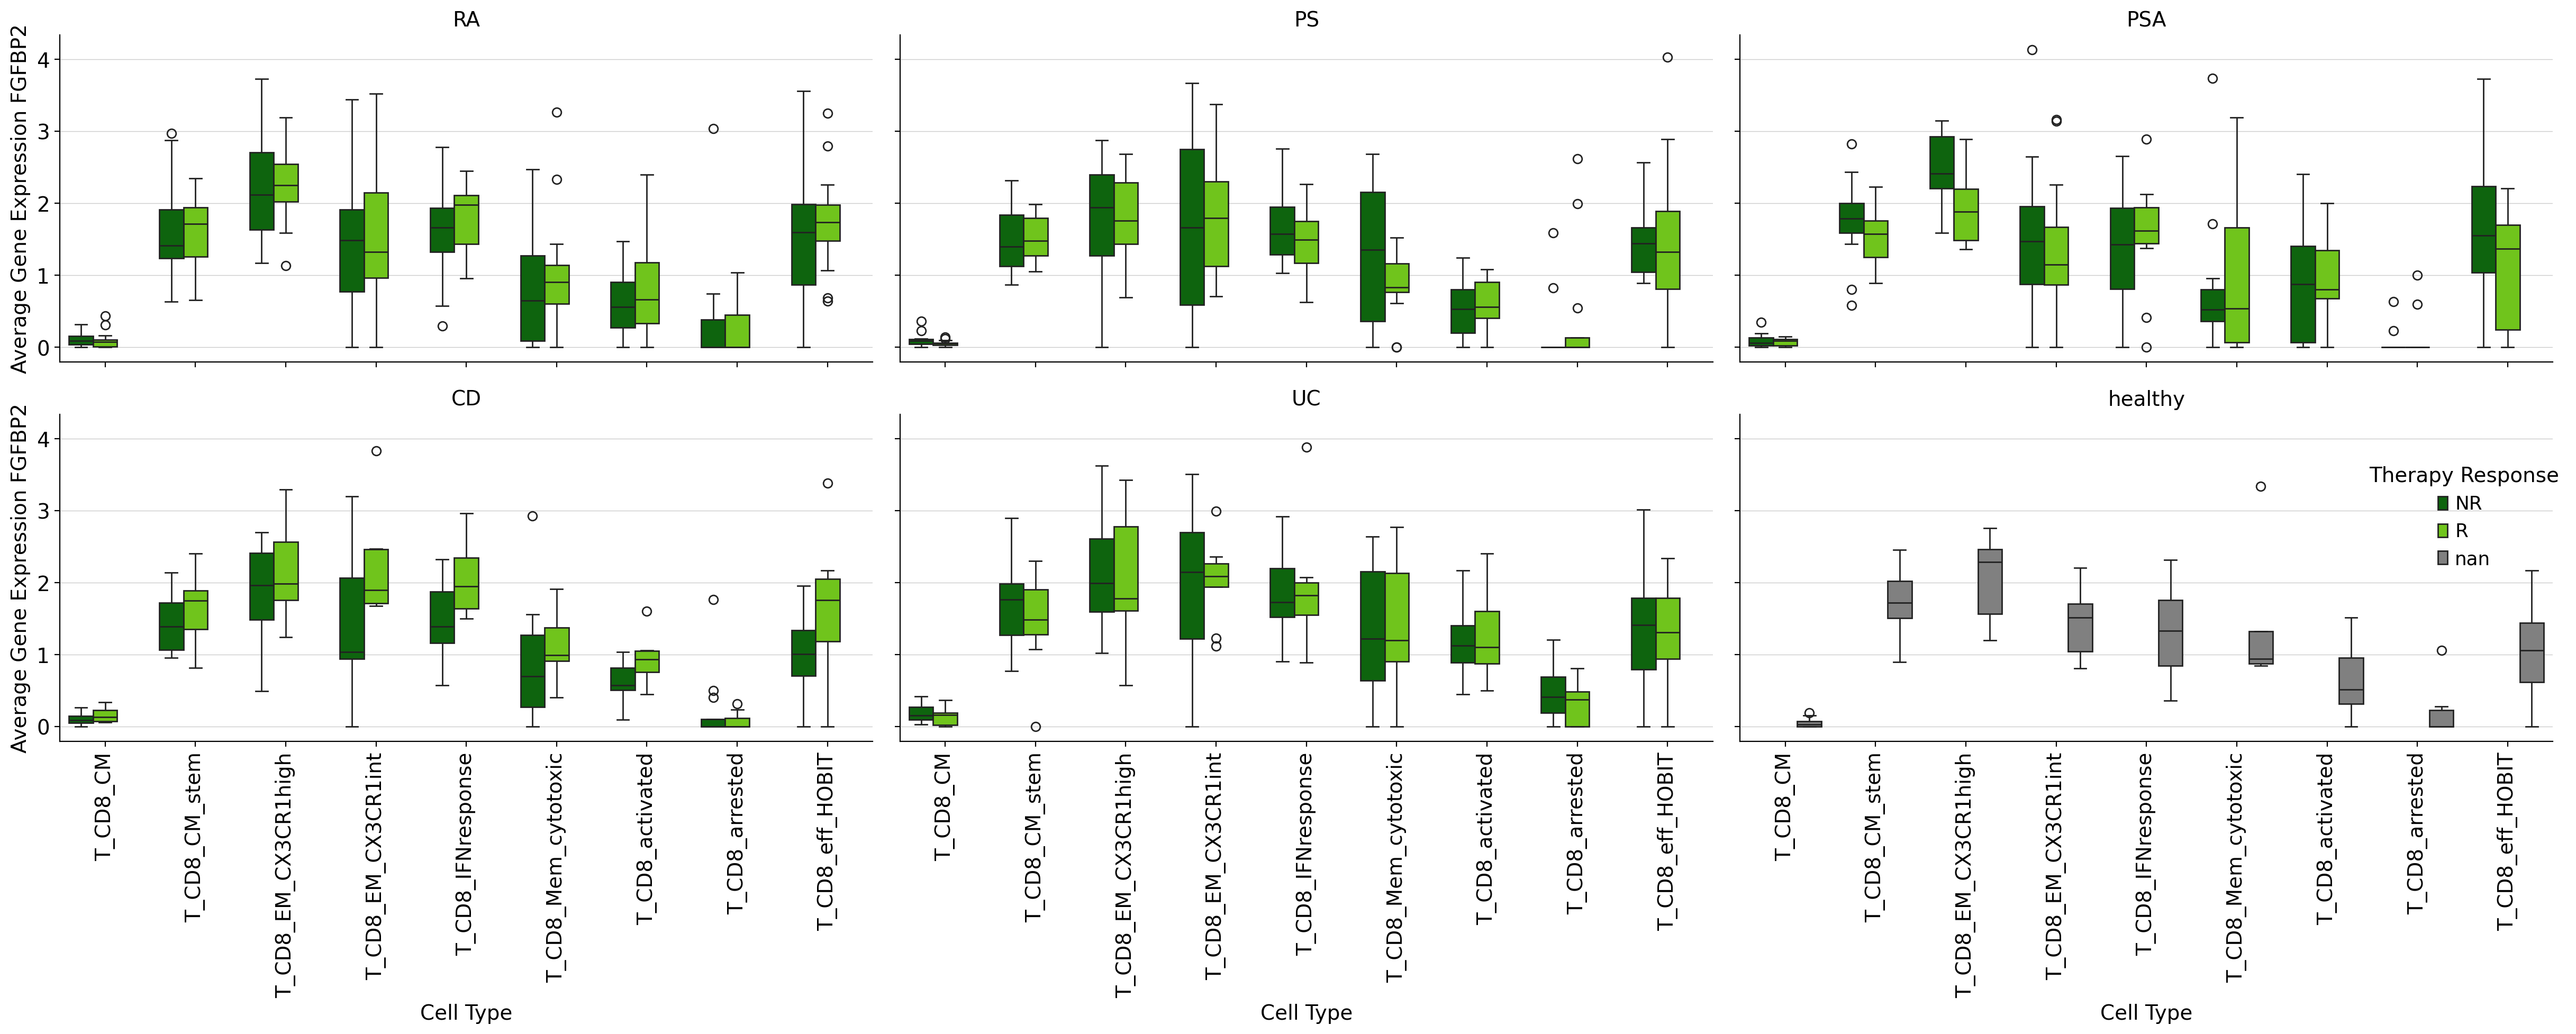

<Figure size 2000x1000 with 0 Axes>

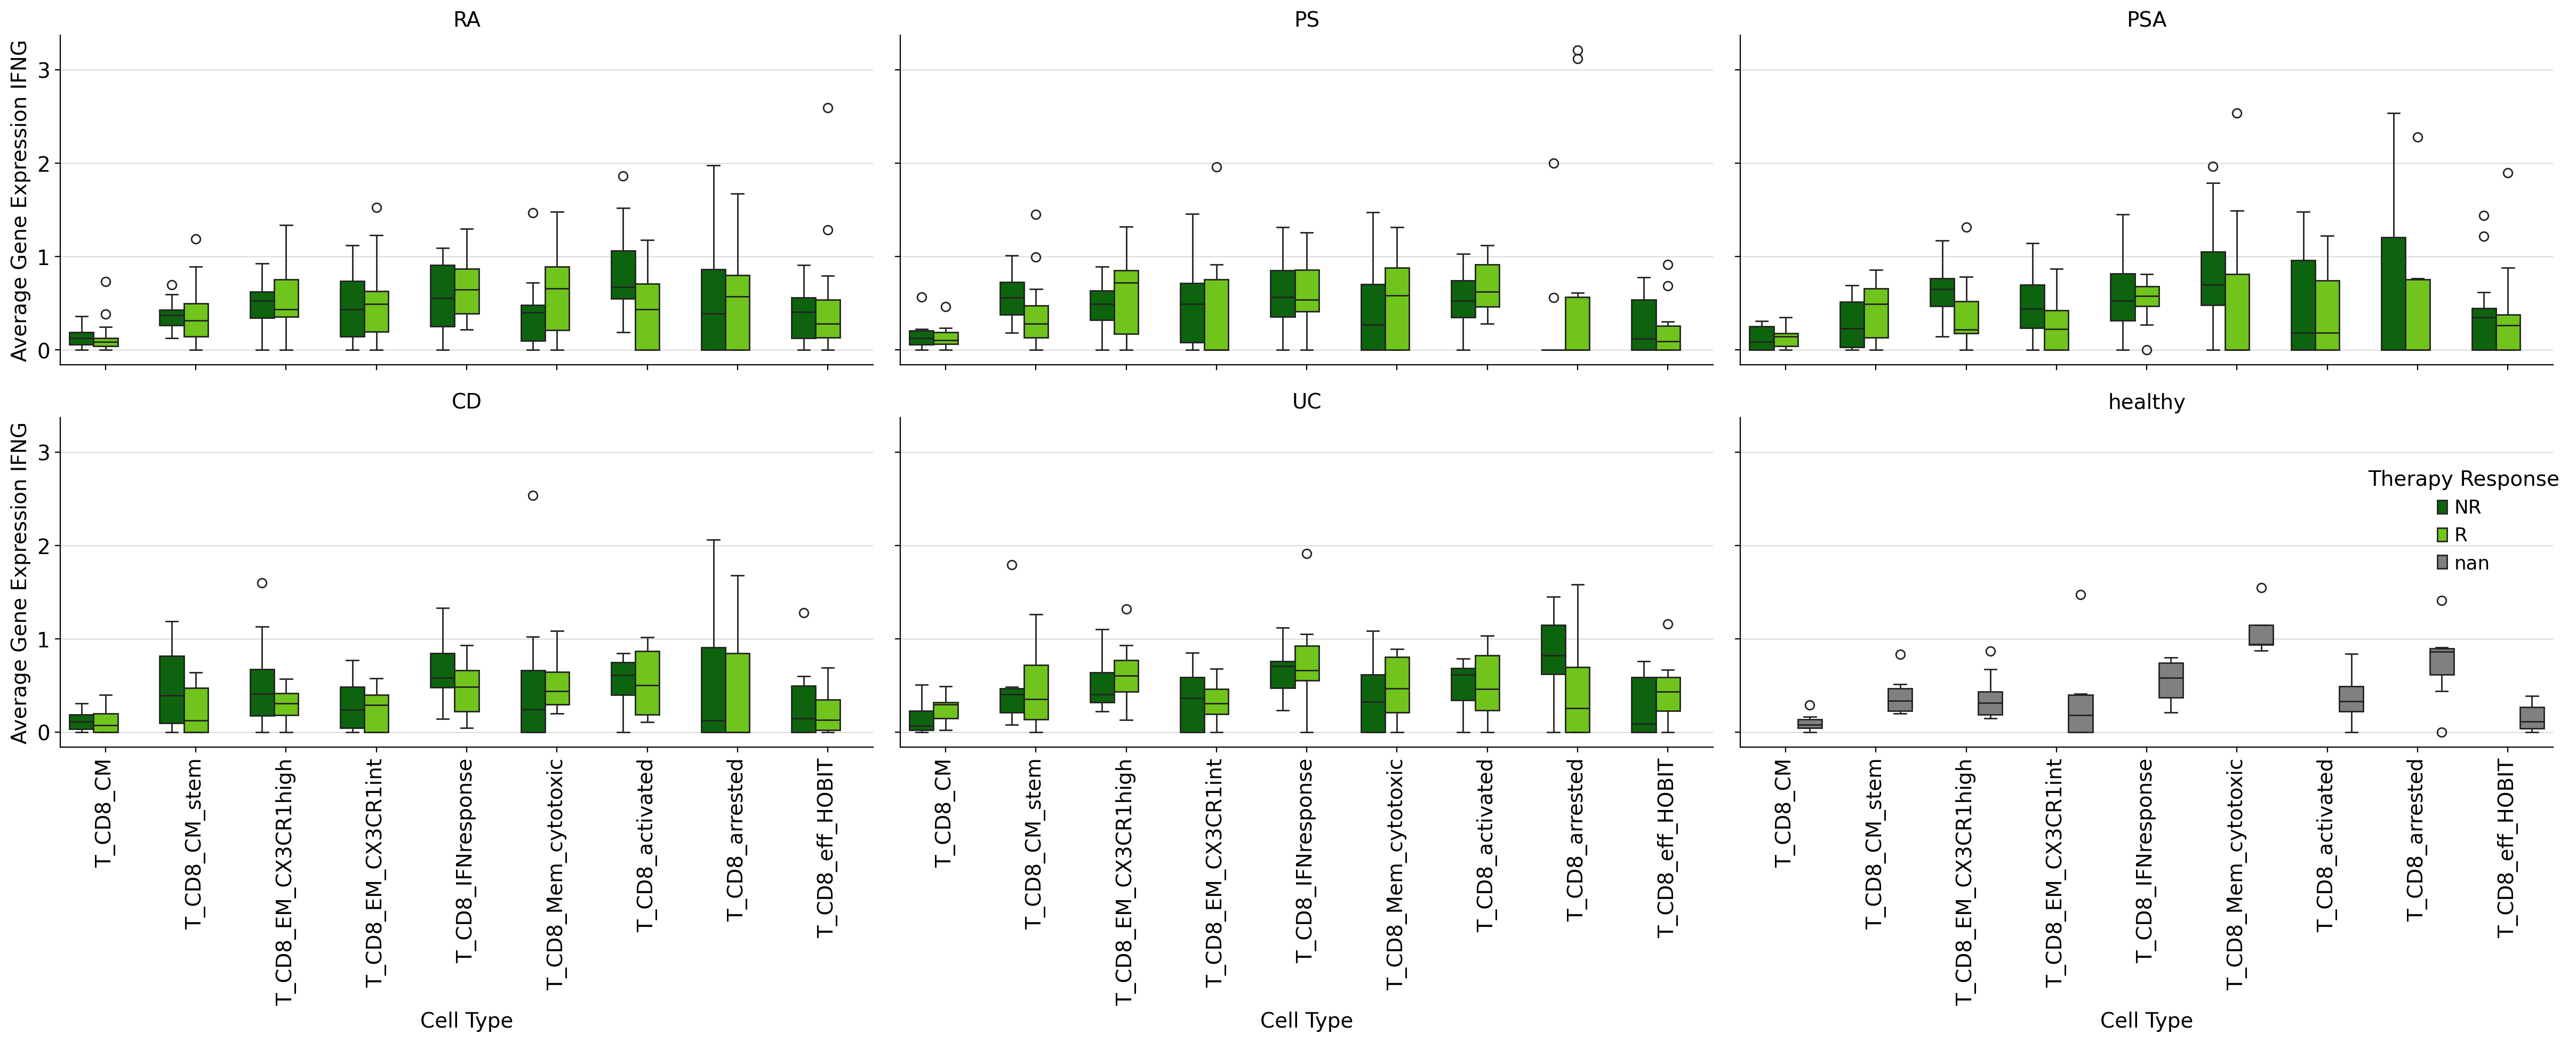

<Figure size 2000x1000 with 0 Axes>

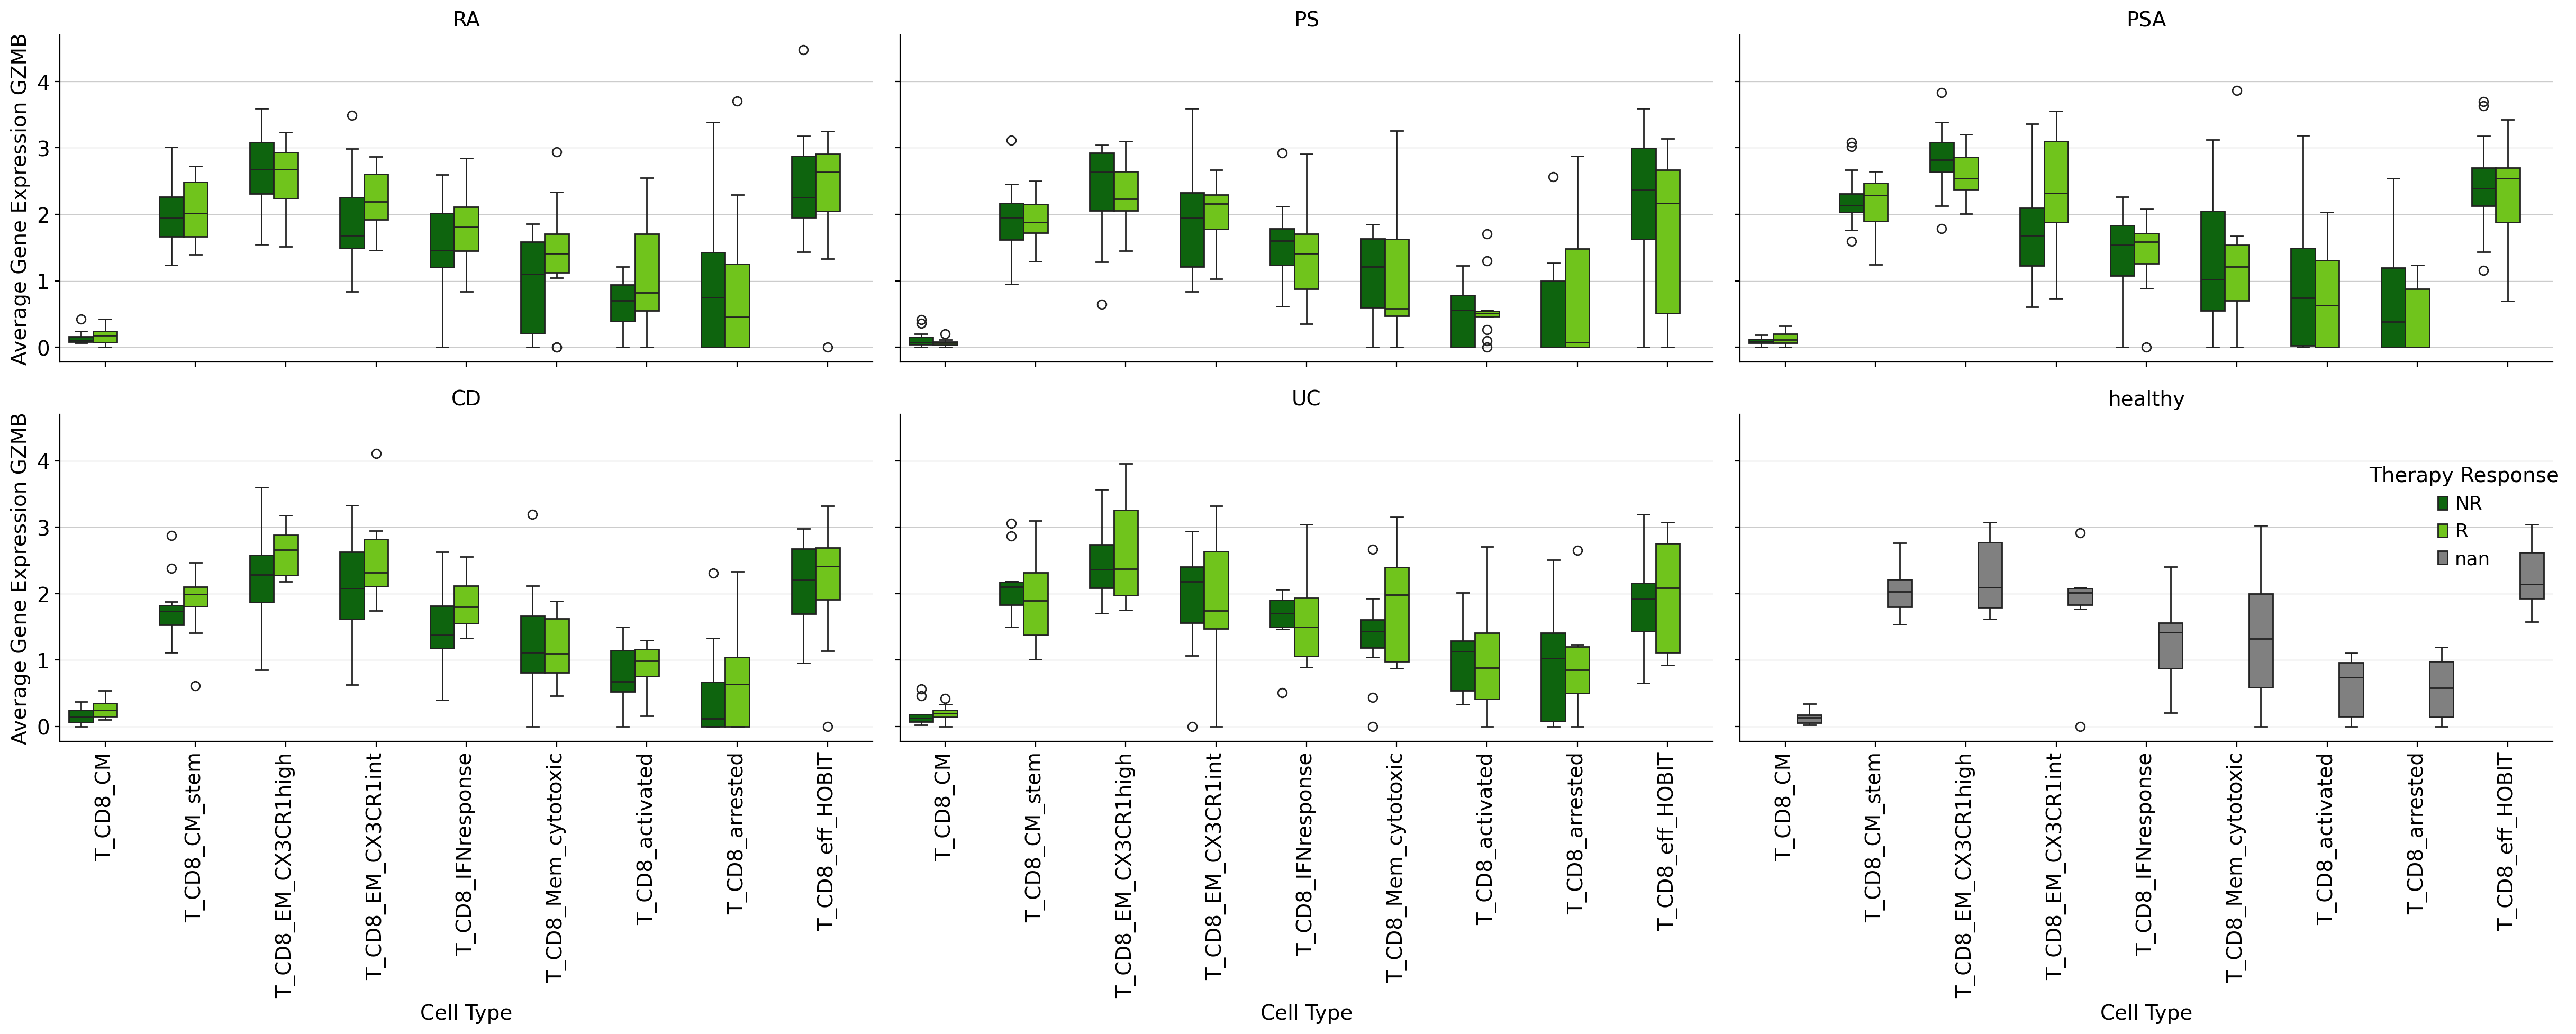

<Figure size 2000x1000 with 0 Axes>

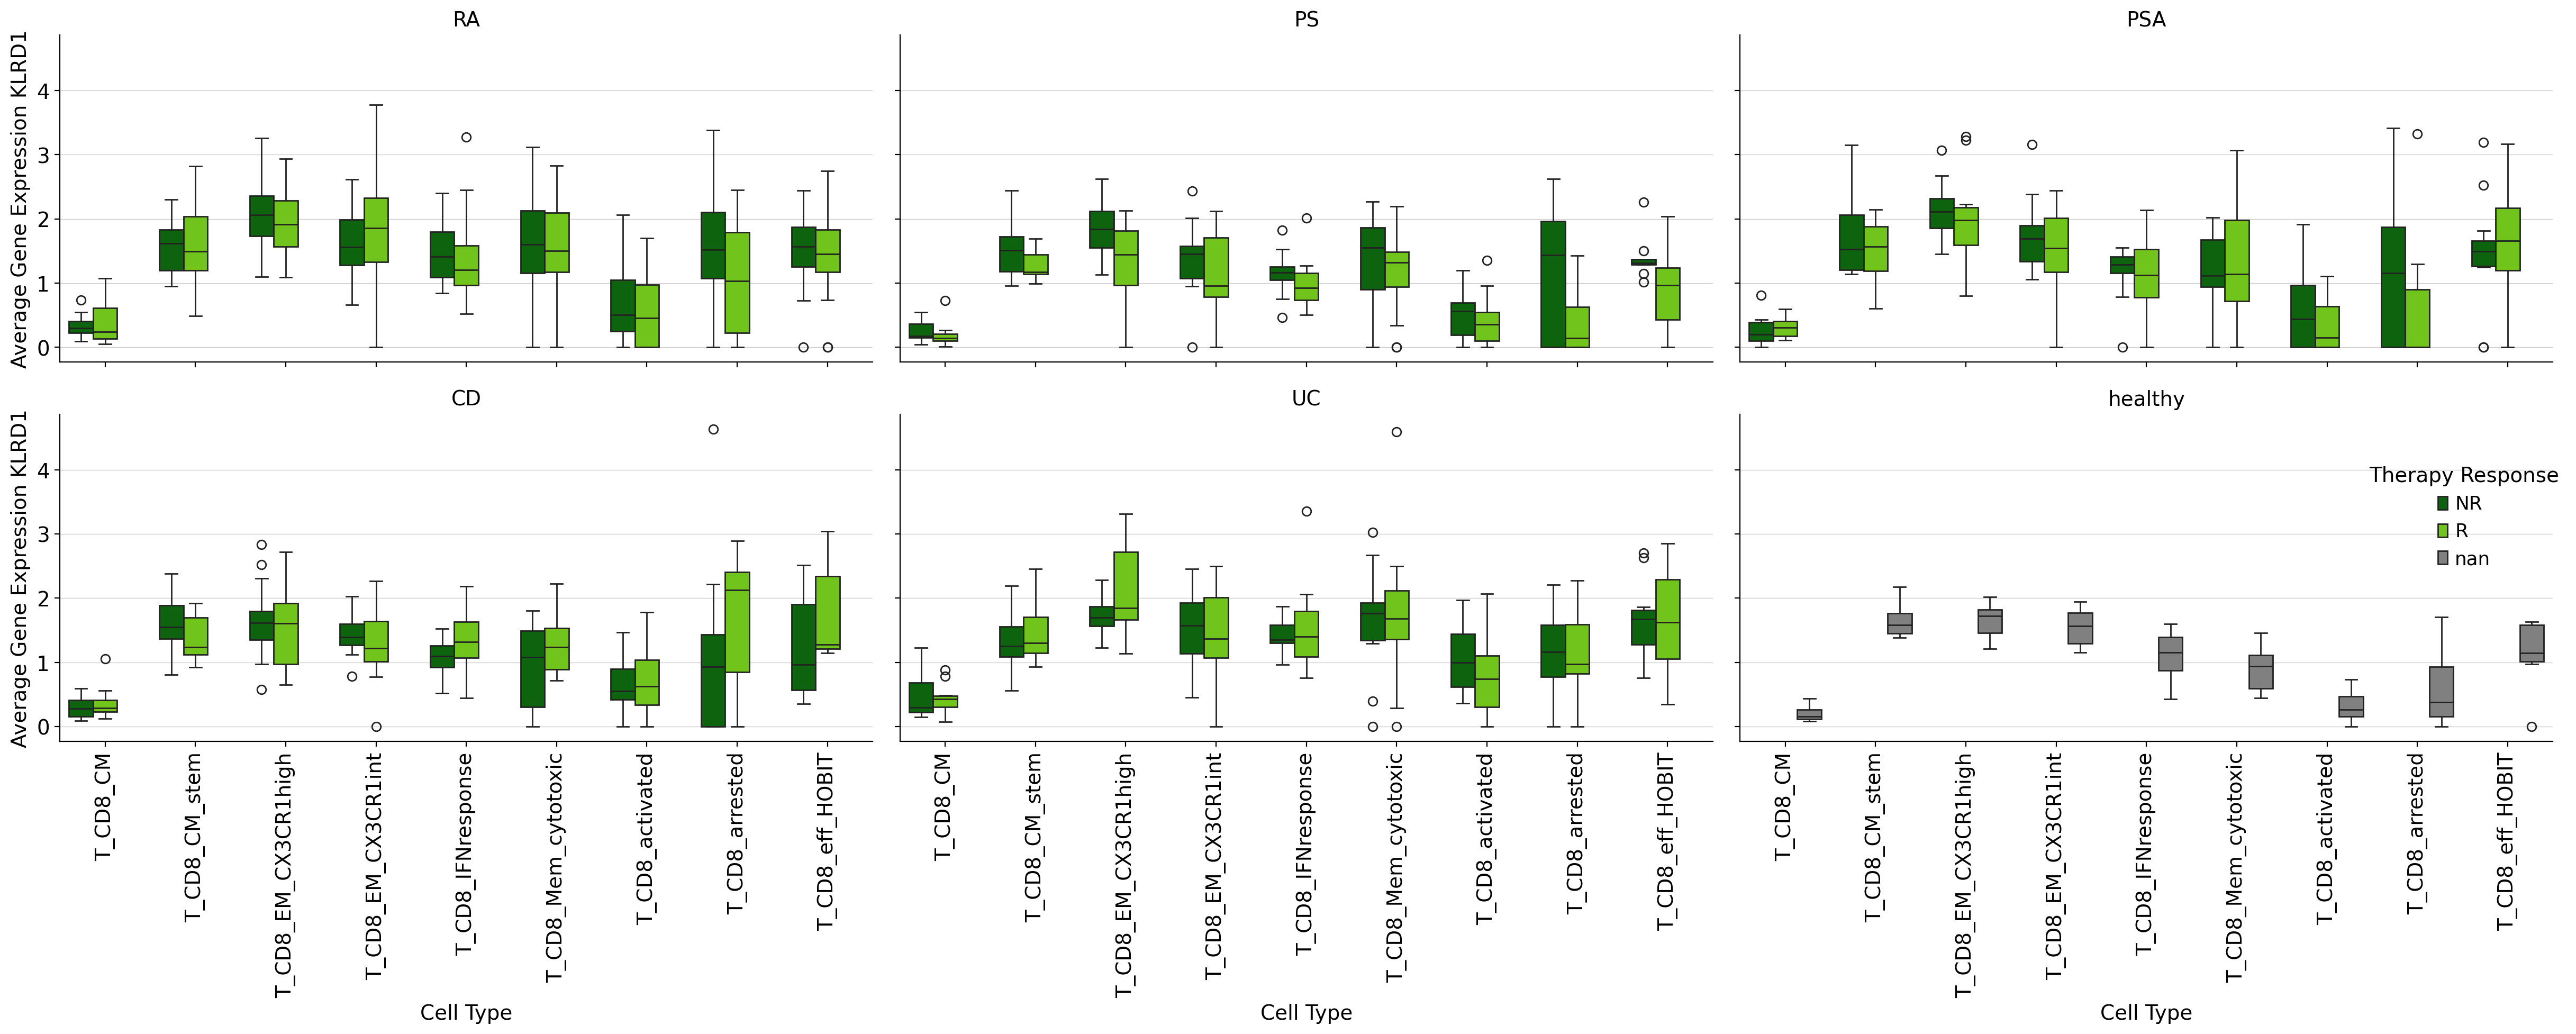

<Figure size 2000x1000 with 0 Axes>

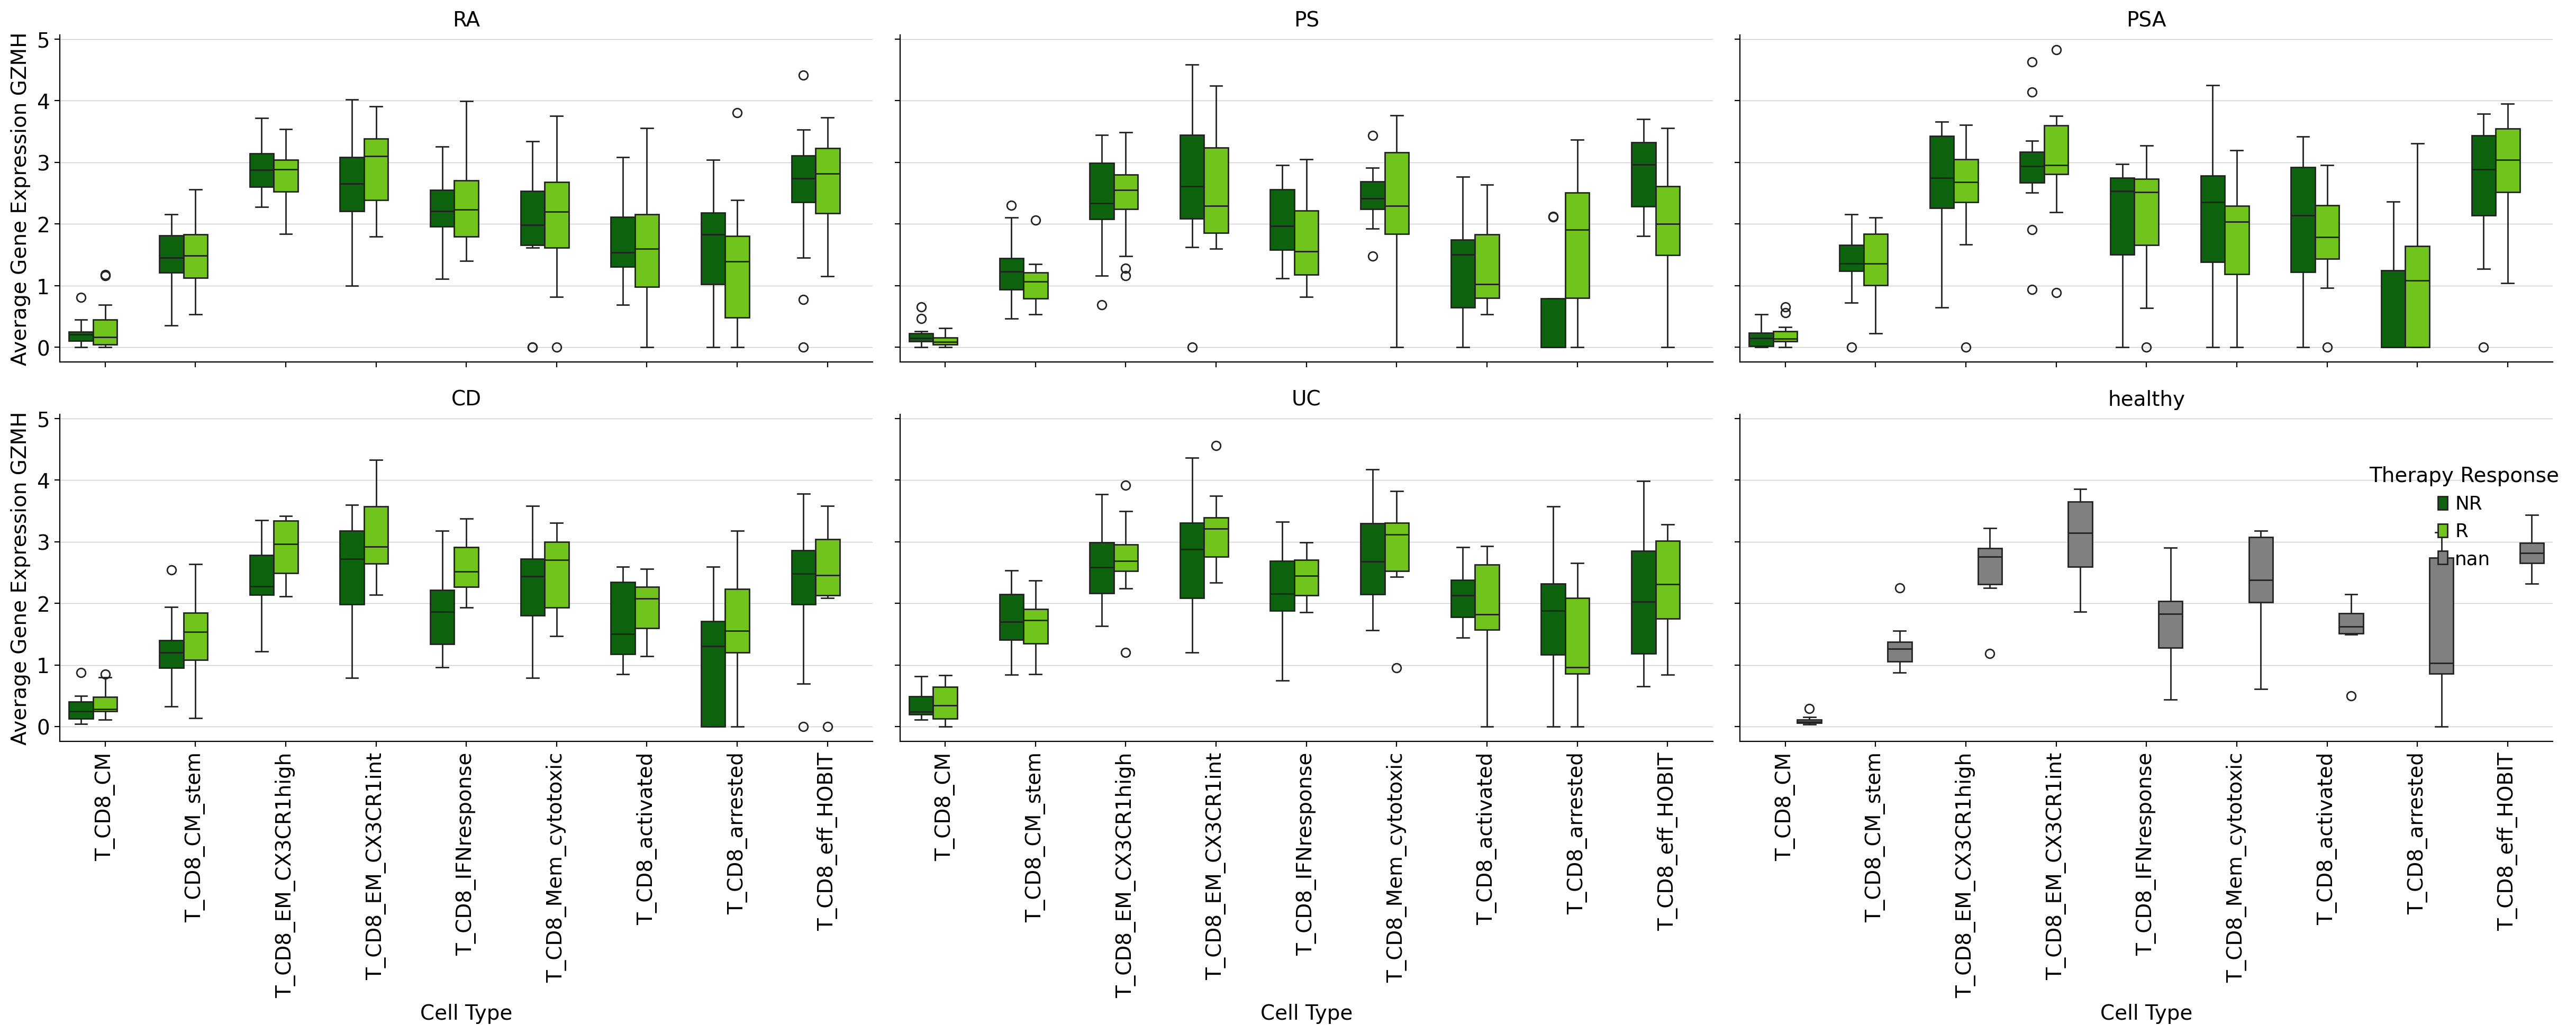

In [234]:
for gene in genes:
    grouped_data = adata.obs.groupby(['sampleID', 'disease', 'Level2', 'therapyResponse'])[gene].mean().reset_index()
    
    plt.figure(figsize=(20, 10))
    # Facet by disease
    g = sns.FacetGrid(grouped_data, col="disease", col_wrap=3, sharey=True, height=5, aspect=1.5)
    g.map_dataframe(sns.boxplot, x='Level2', y=gene, hue='therapyResponse', palette=response_palette)

    # Rotate x tick labels
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(90)
    
    # Adjust the title and labels
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Cell Type", f"Average Gene Expression {gene}")
    g.add_legend(title="Therapy Response")
    
    plt.tight_layout()
    plt.show()

    #[ "T_CD8_CM", "T_CD8_CM_stem", "T_CD8_IFNresponse", "T_CD8_EM_CX3CR1int", "T_CD8_EM_CX3CR1high", "T_CD8_Mem_cytotoxic"]:

<Figure size 2000x1000 with 0 Axes>

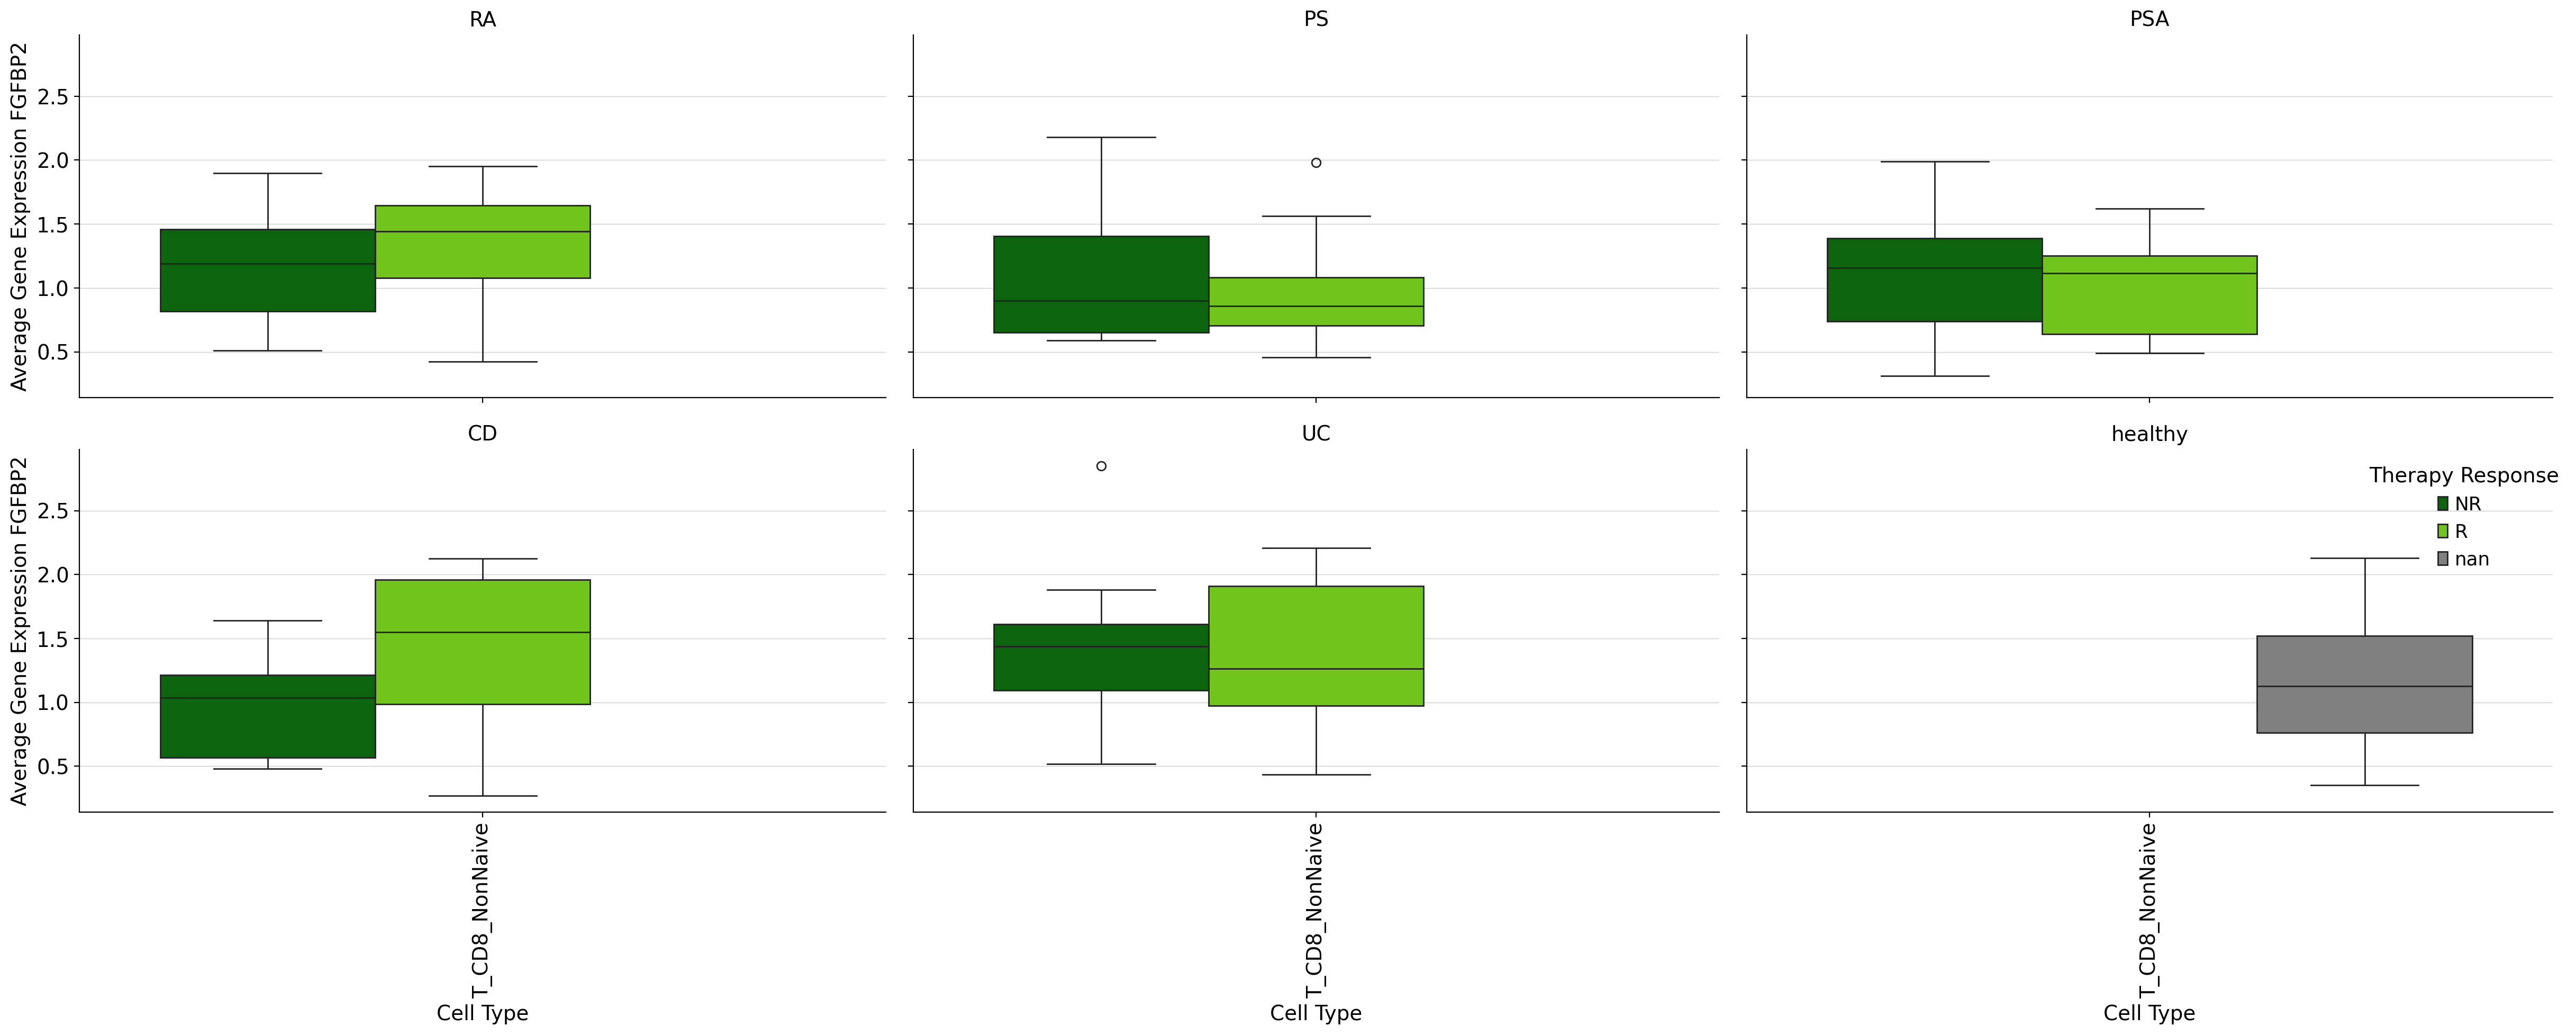

<Figure size 2000x1000 with 0 Axes>

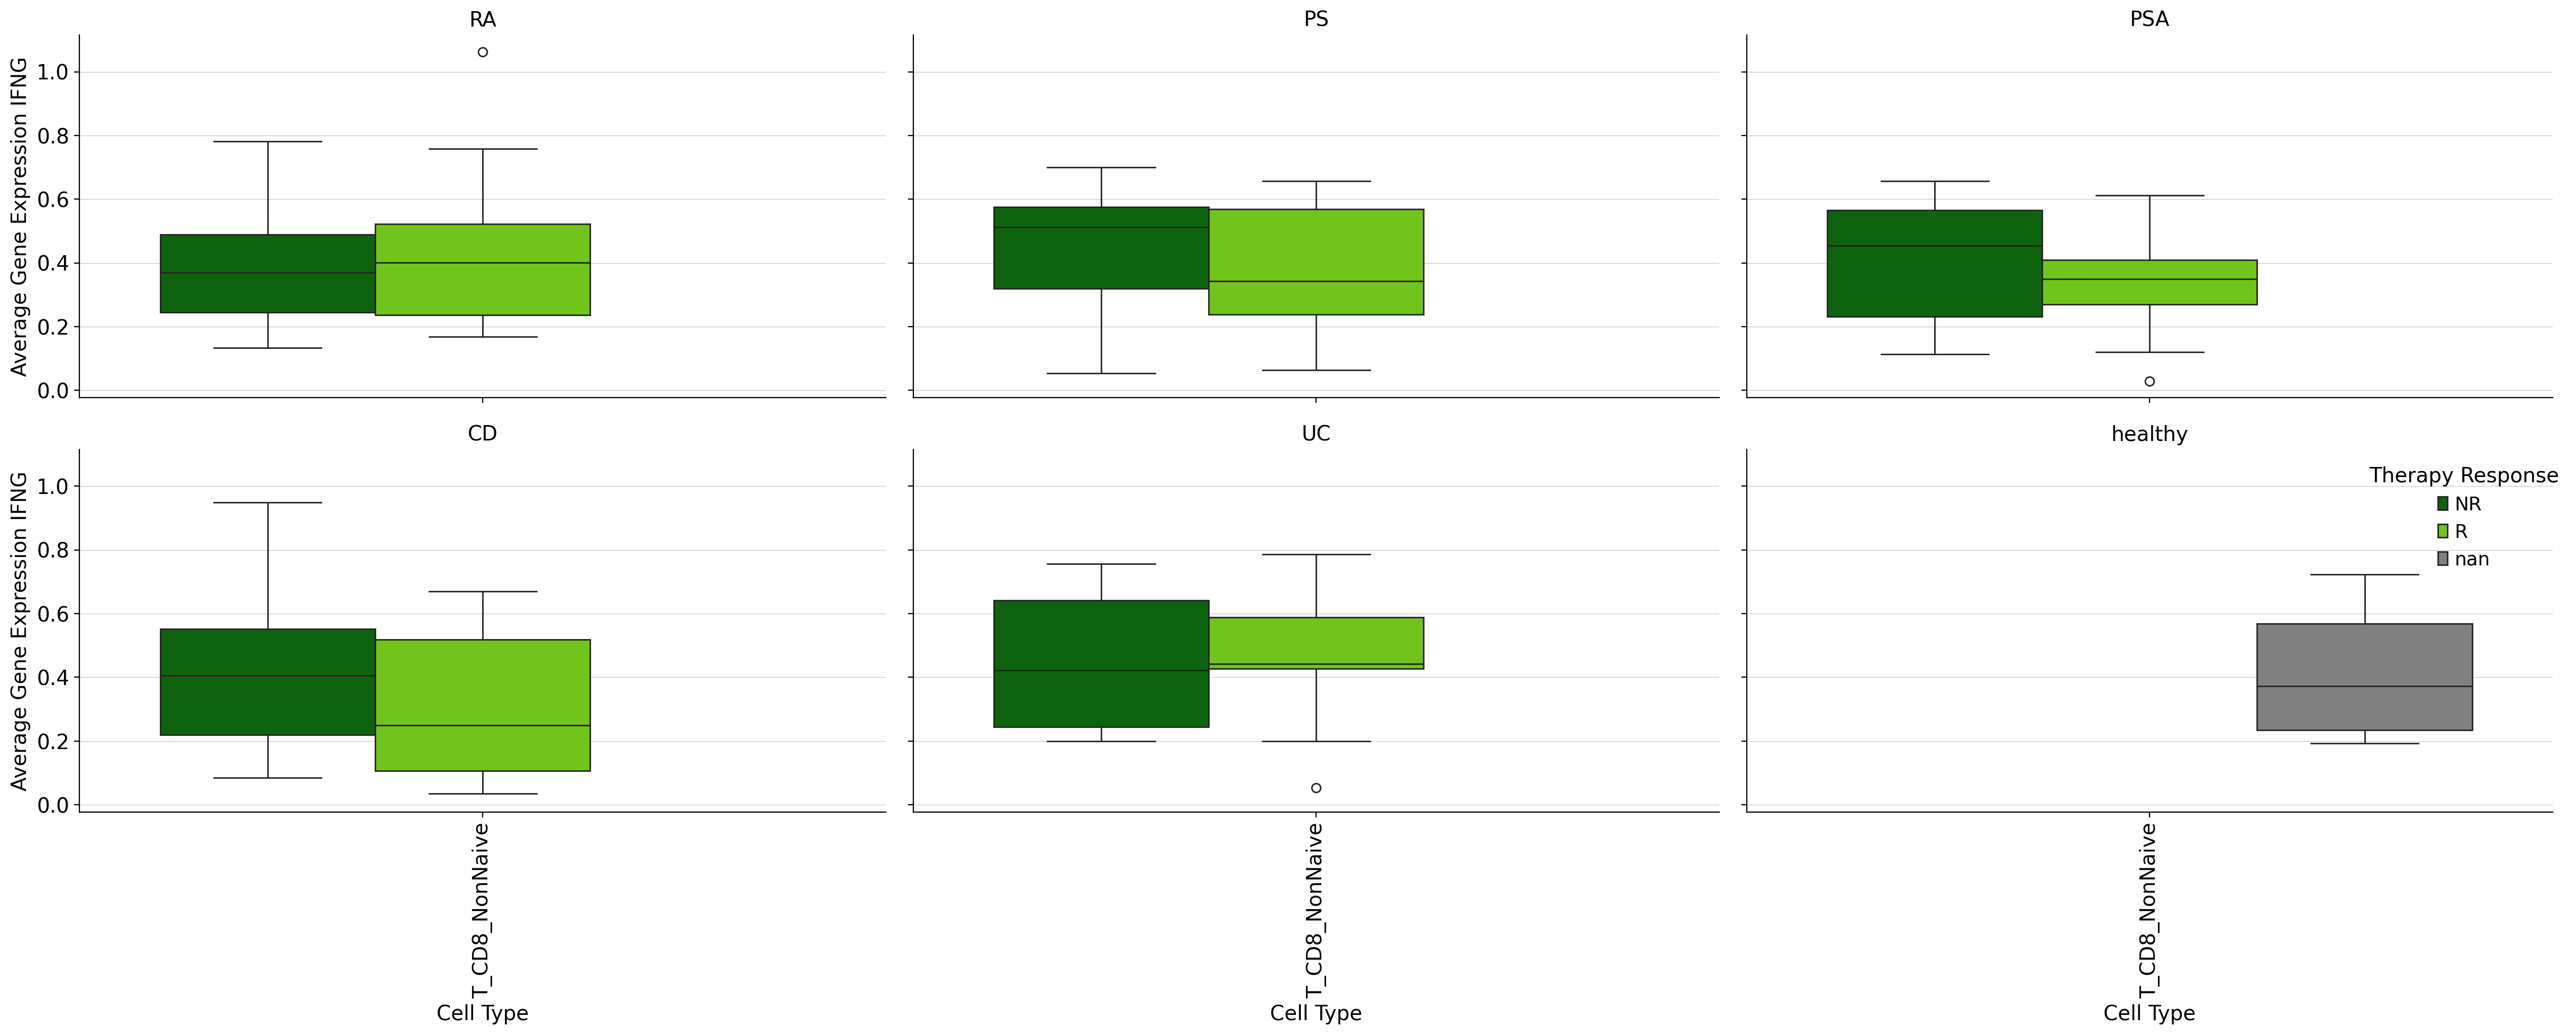

<Figure size 2000x1000 with 0 Axes>

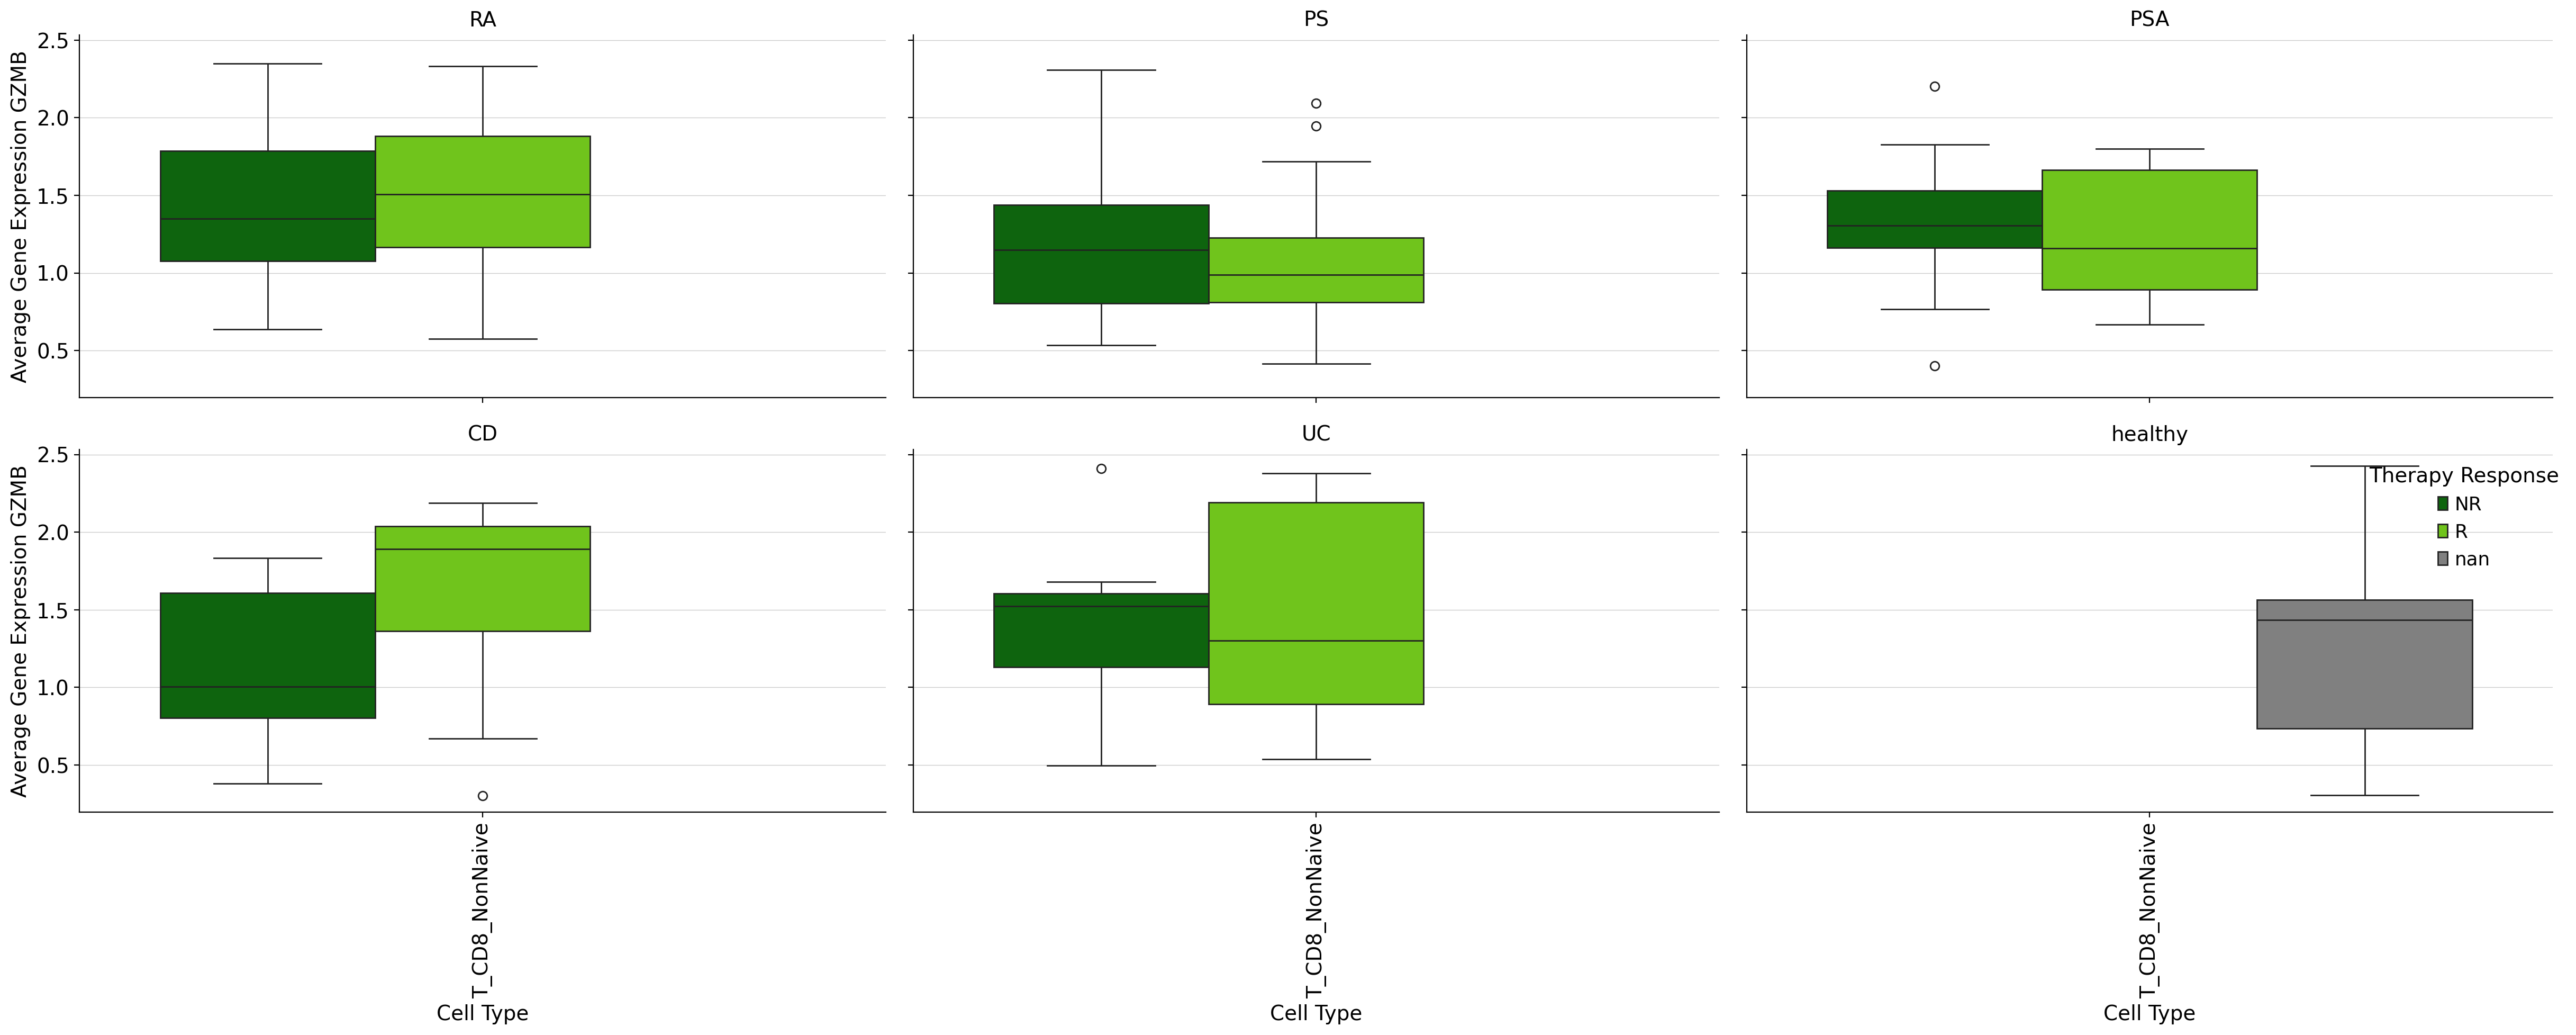

<Figure size 2000x1000 with 0 Axes>

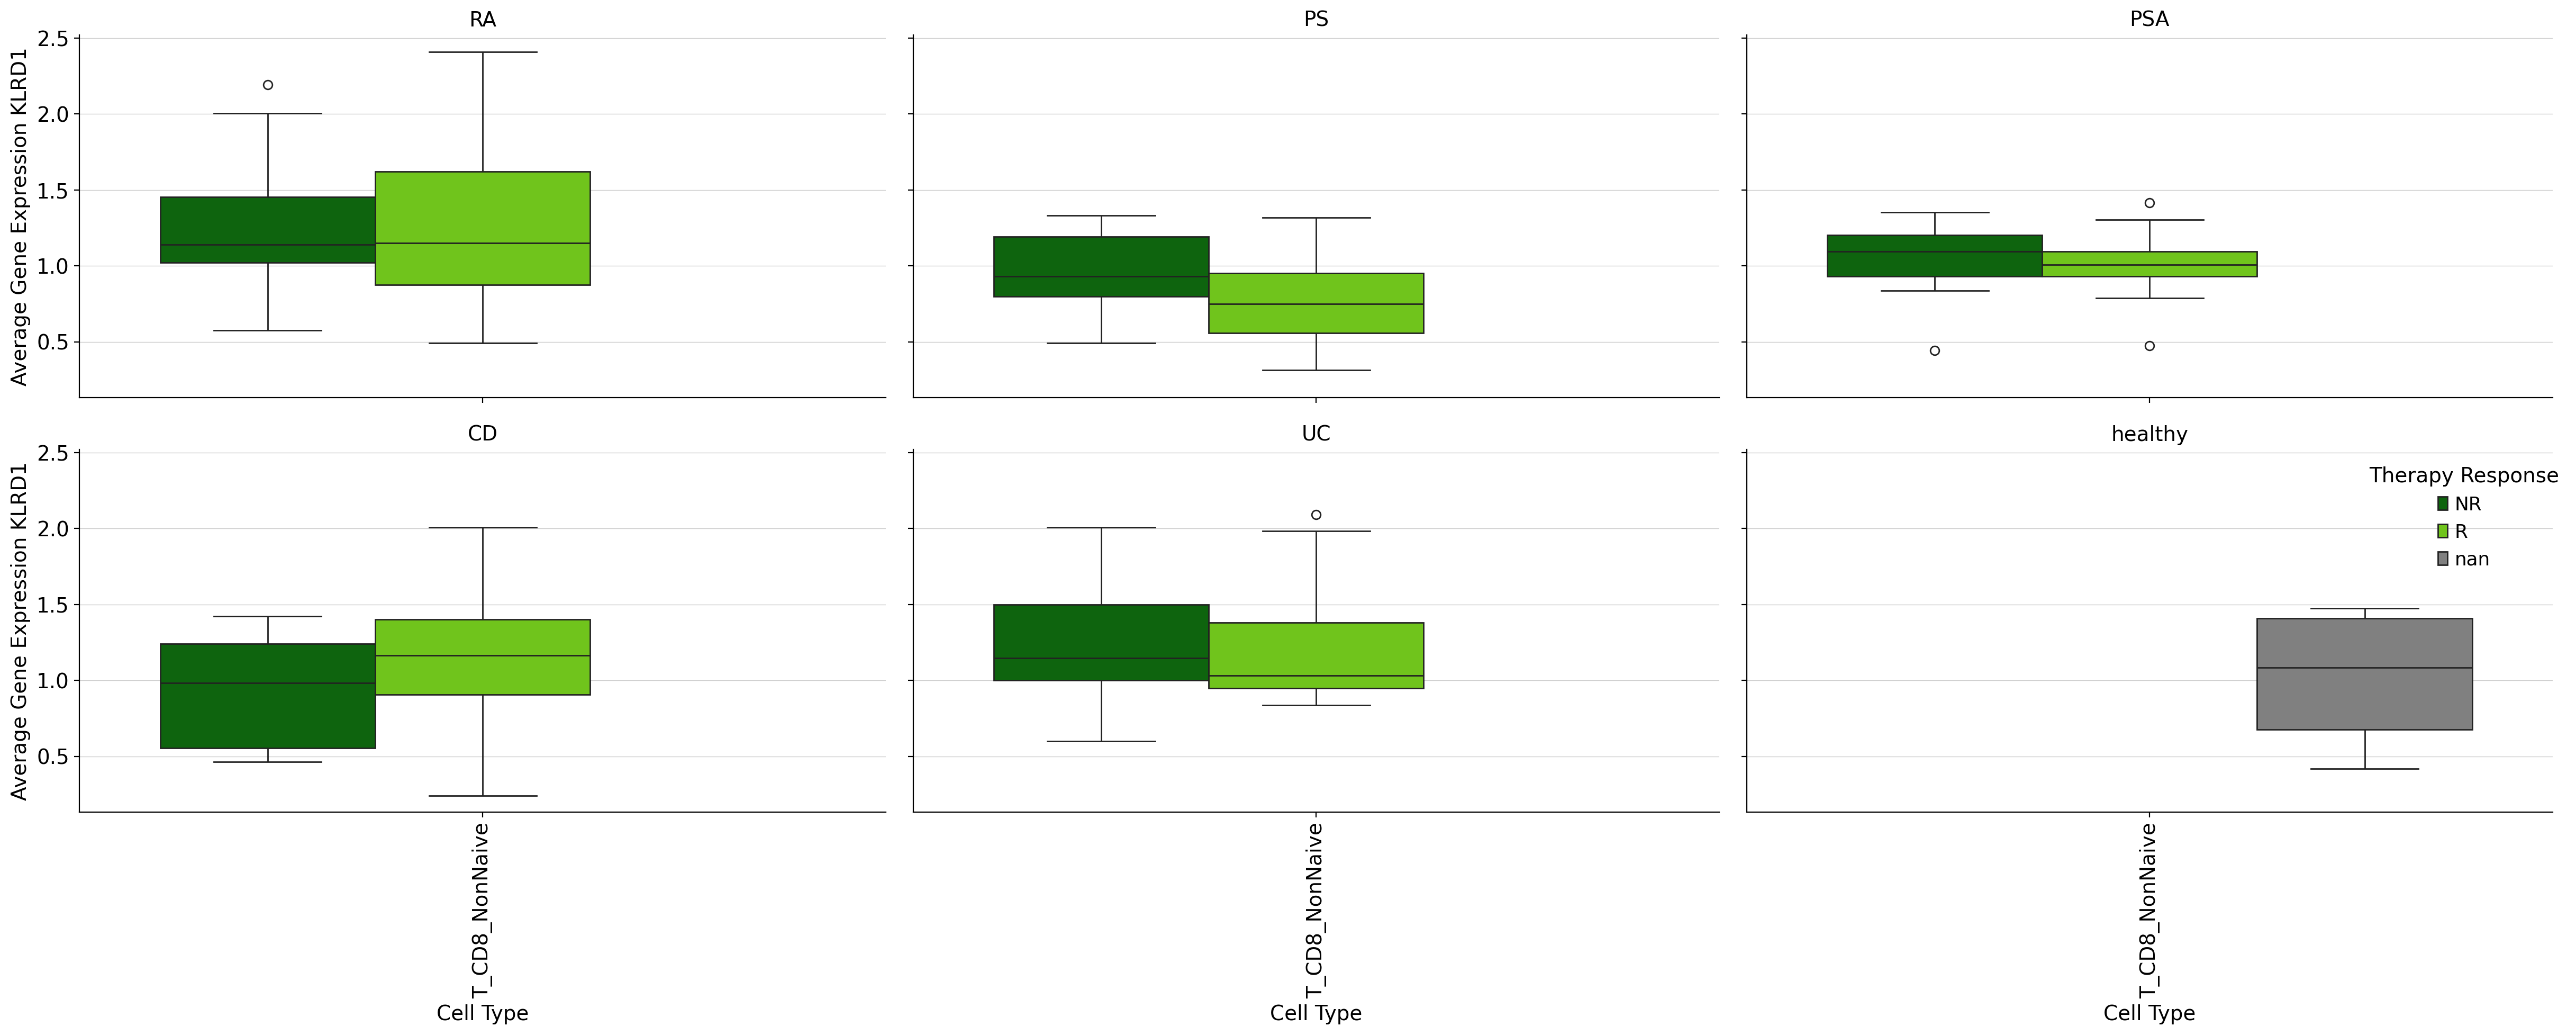

<Figure size 2000x1000 with 0 Axes>

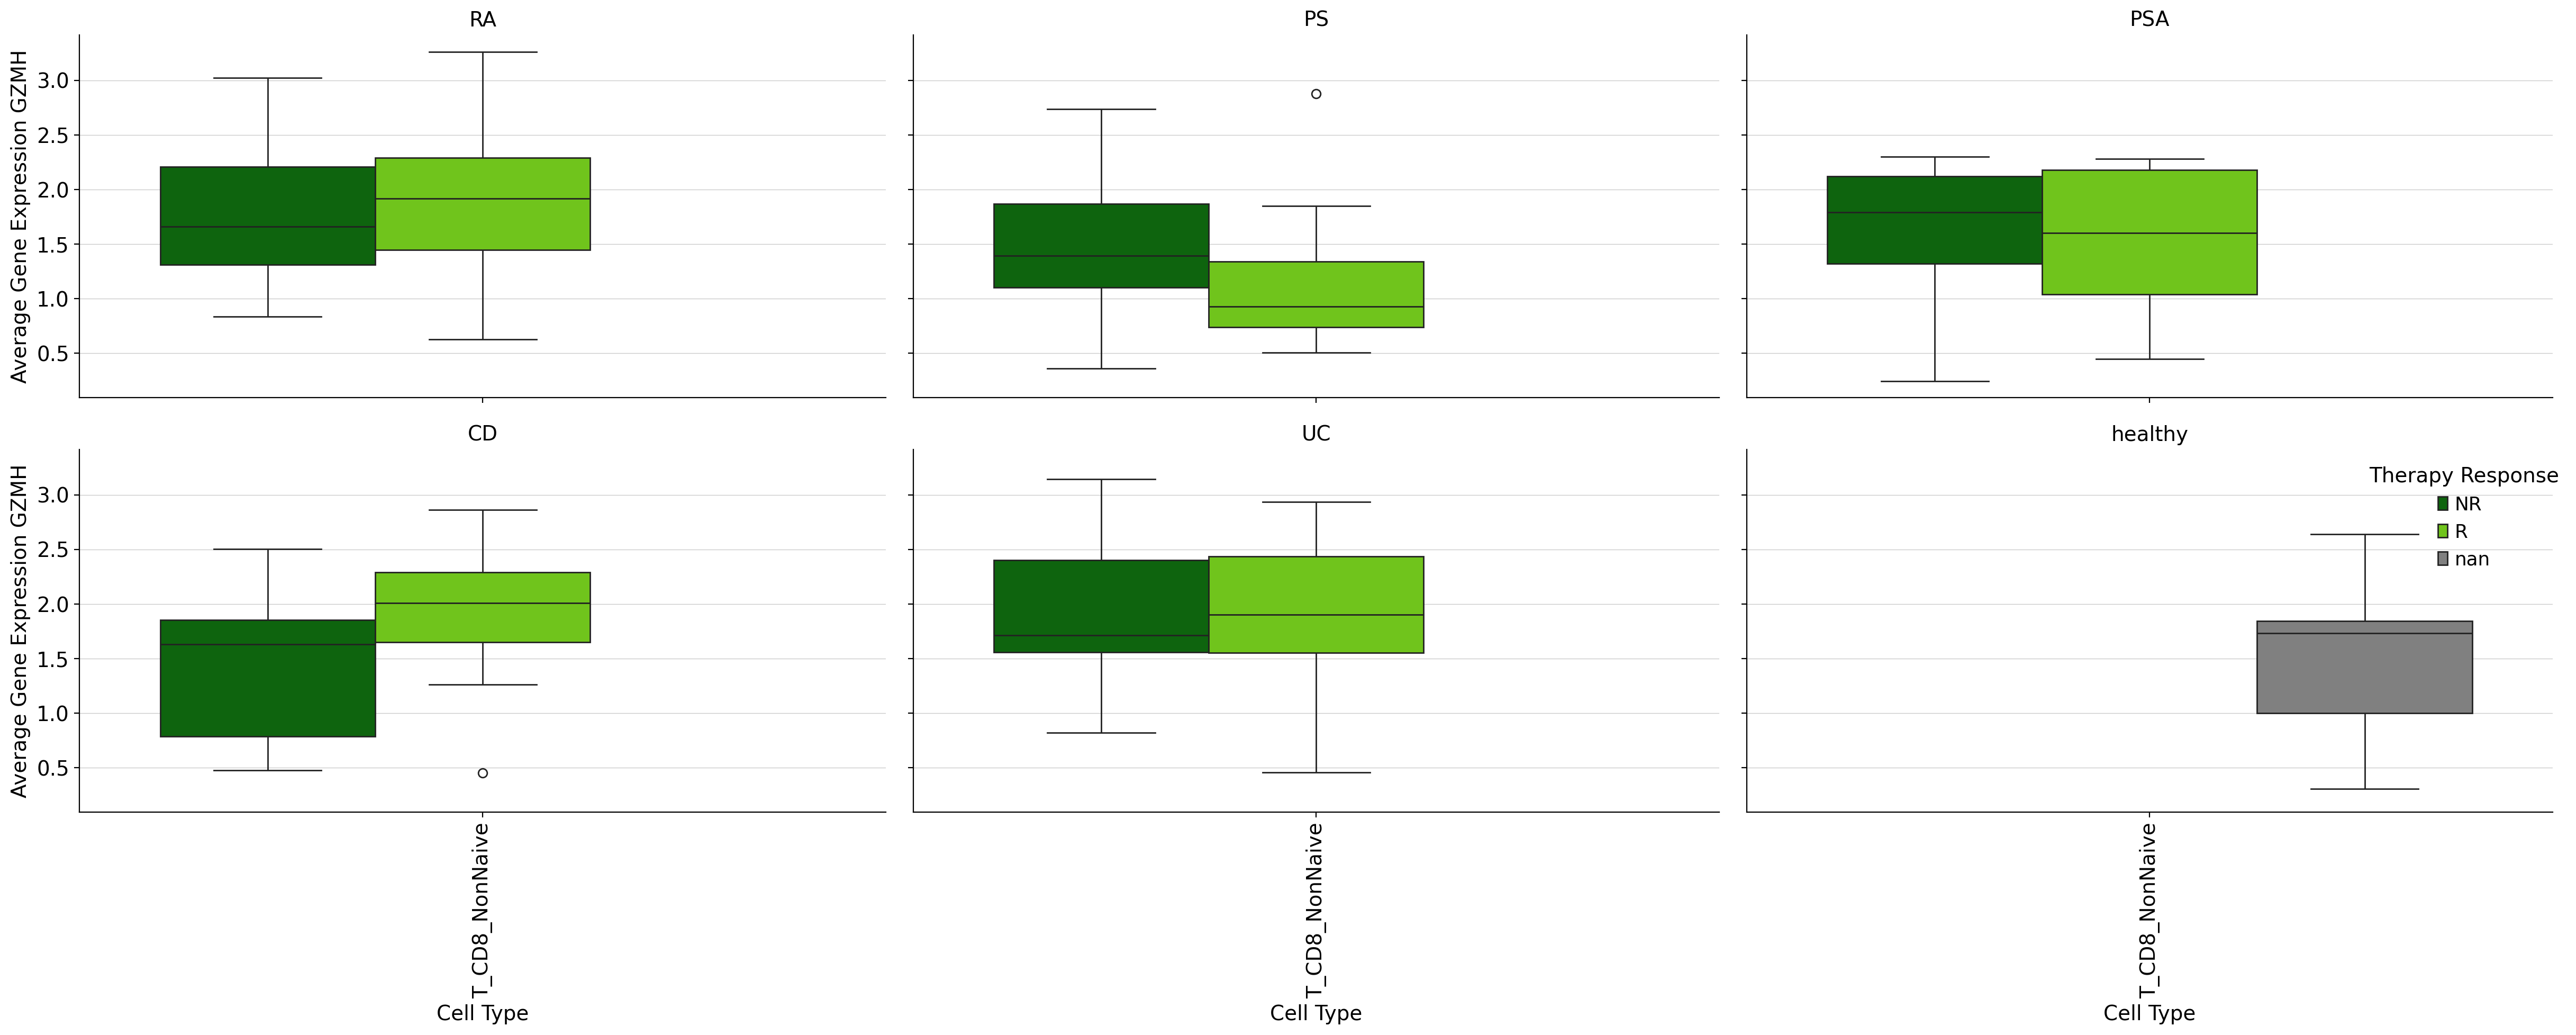

In [235]:
for gene in genes:
    grouped_data = adata.obs.groupby(['sampleID', 'disease', 'Level1', 'therapyResponse'])[gene].mean().reset_index()
    
    plt.figure(figsize=(20, 10))
    # Facet by disease
    g = sns.FacetGrid(grouped_data, col="disease", col_wrap=3, sharey=True, height=5, aspect=1.5)
    g.map_dataframe(sns.boxplot, x='Level1', y=gene, hue='therapyResponse', palette=response_palette)

    # Rotate x tick labels
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(90)
    
    # Adjust the title and labels
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Cell Type", f"Average Gene Expression {gene}")
    g.add_legend(title="Therapy Response")
    
    plt.tight_layout()
    plt.show()

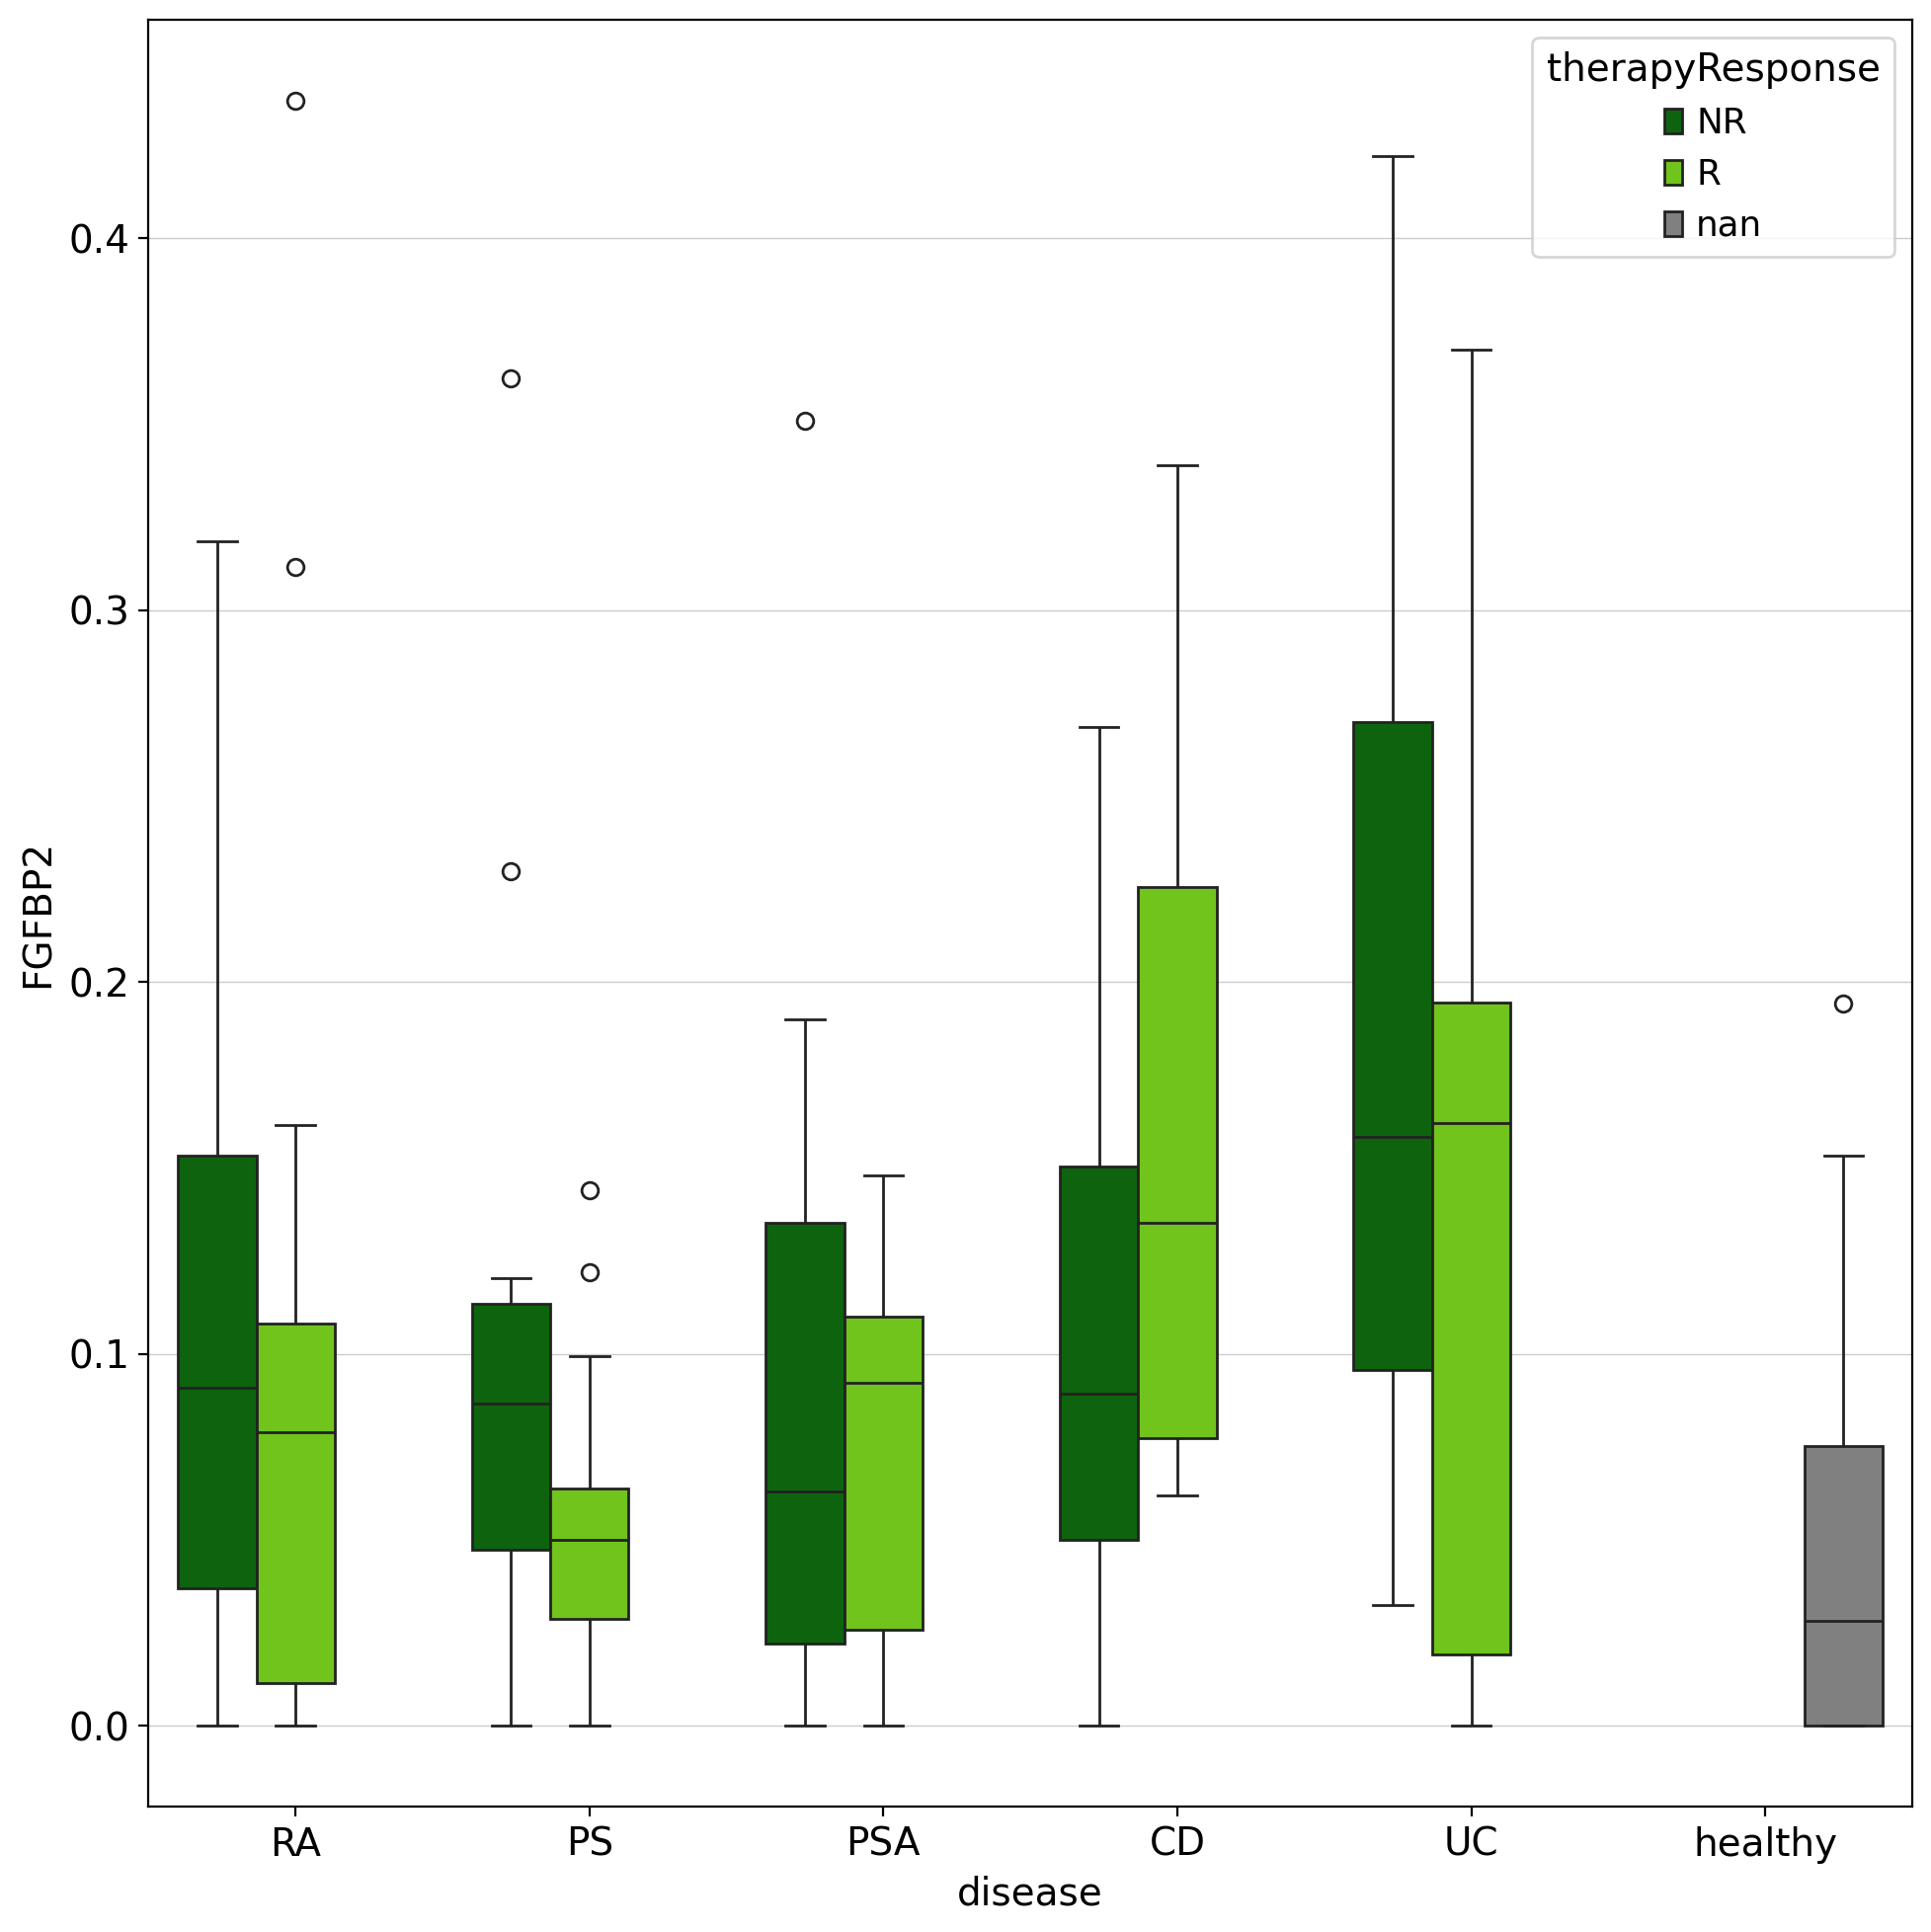

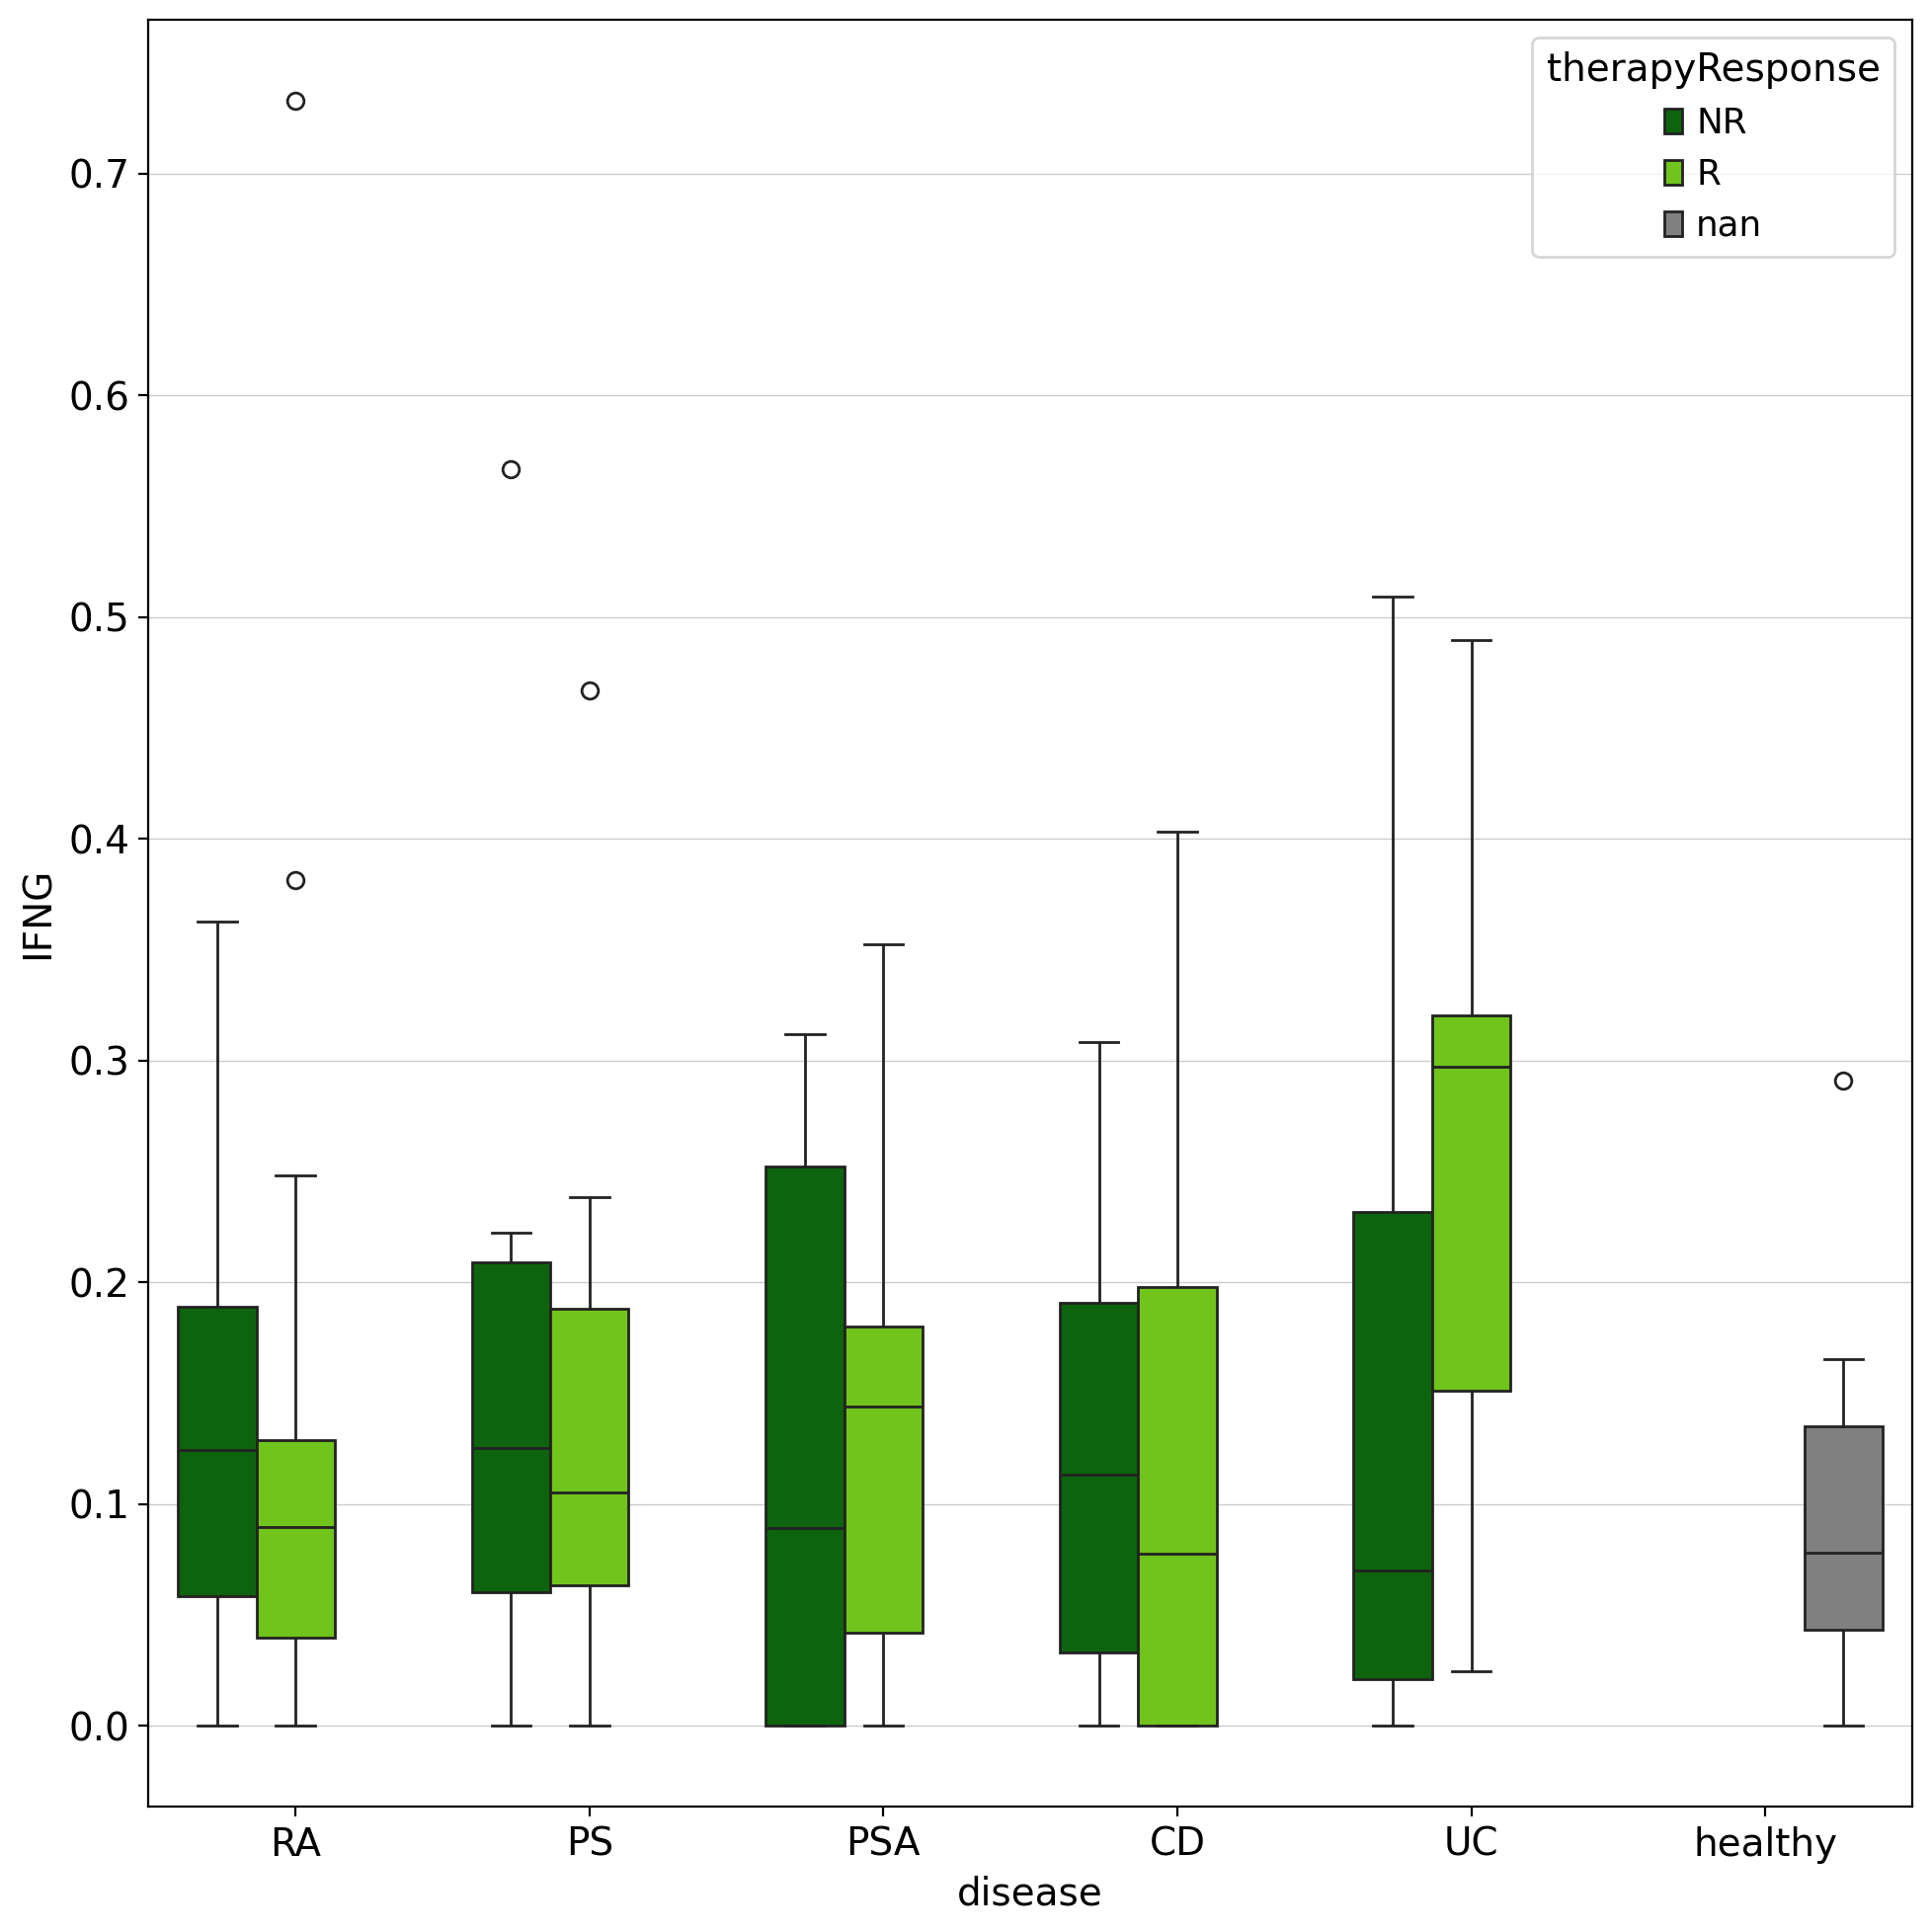

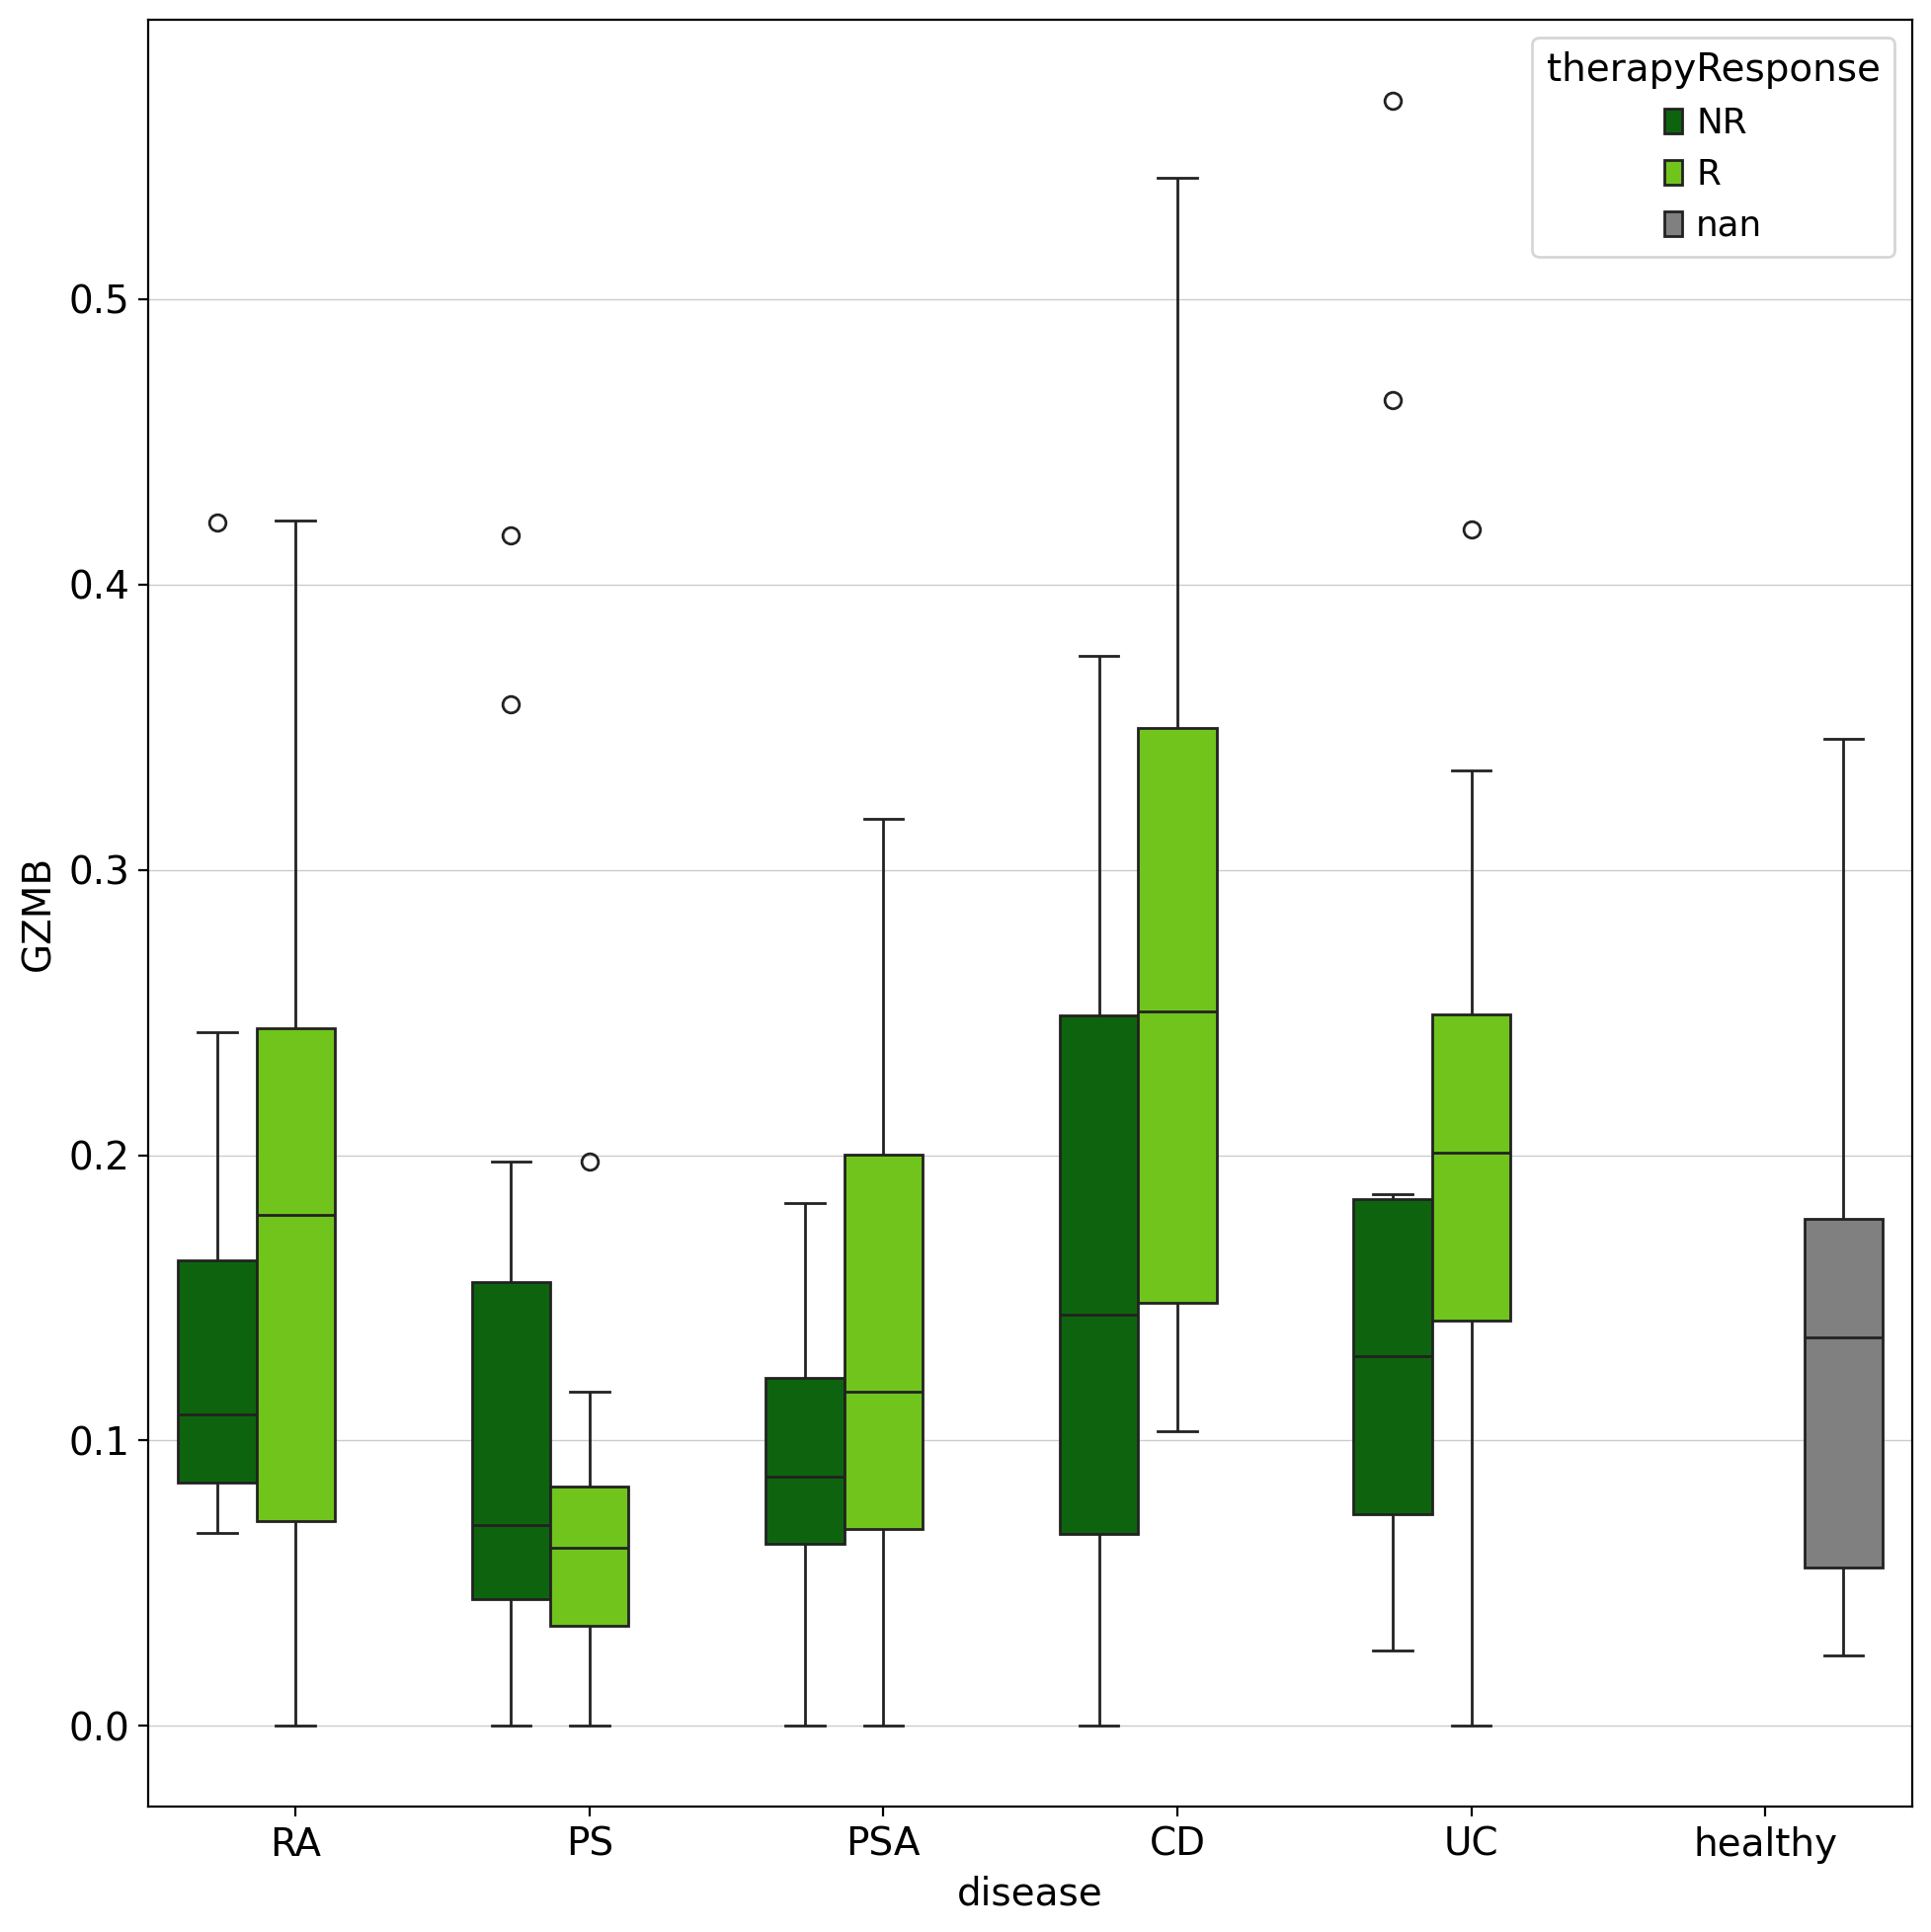

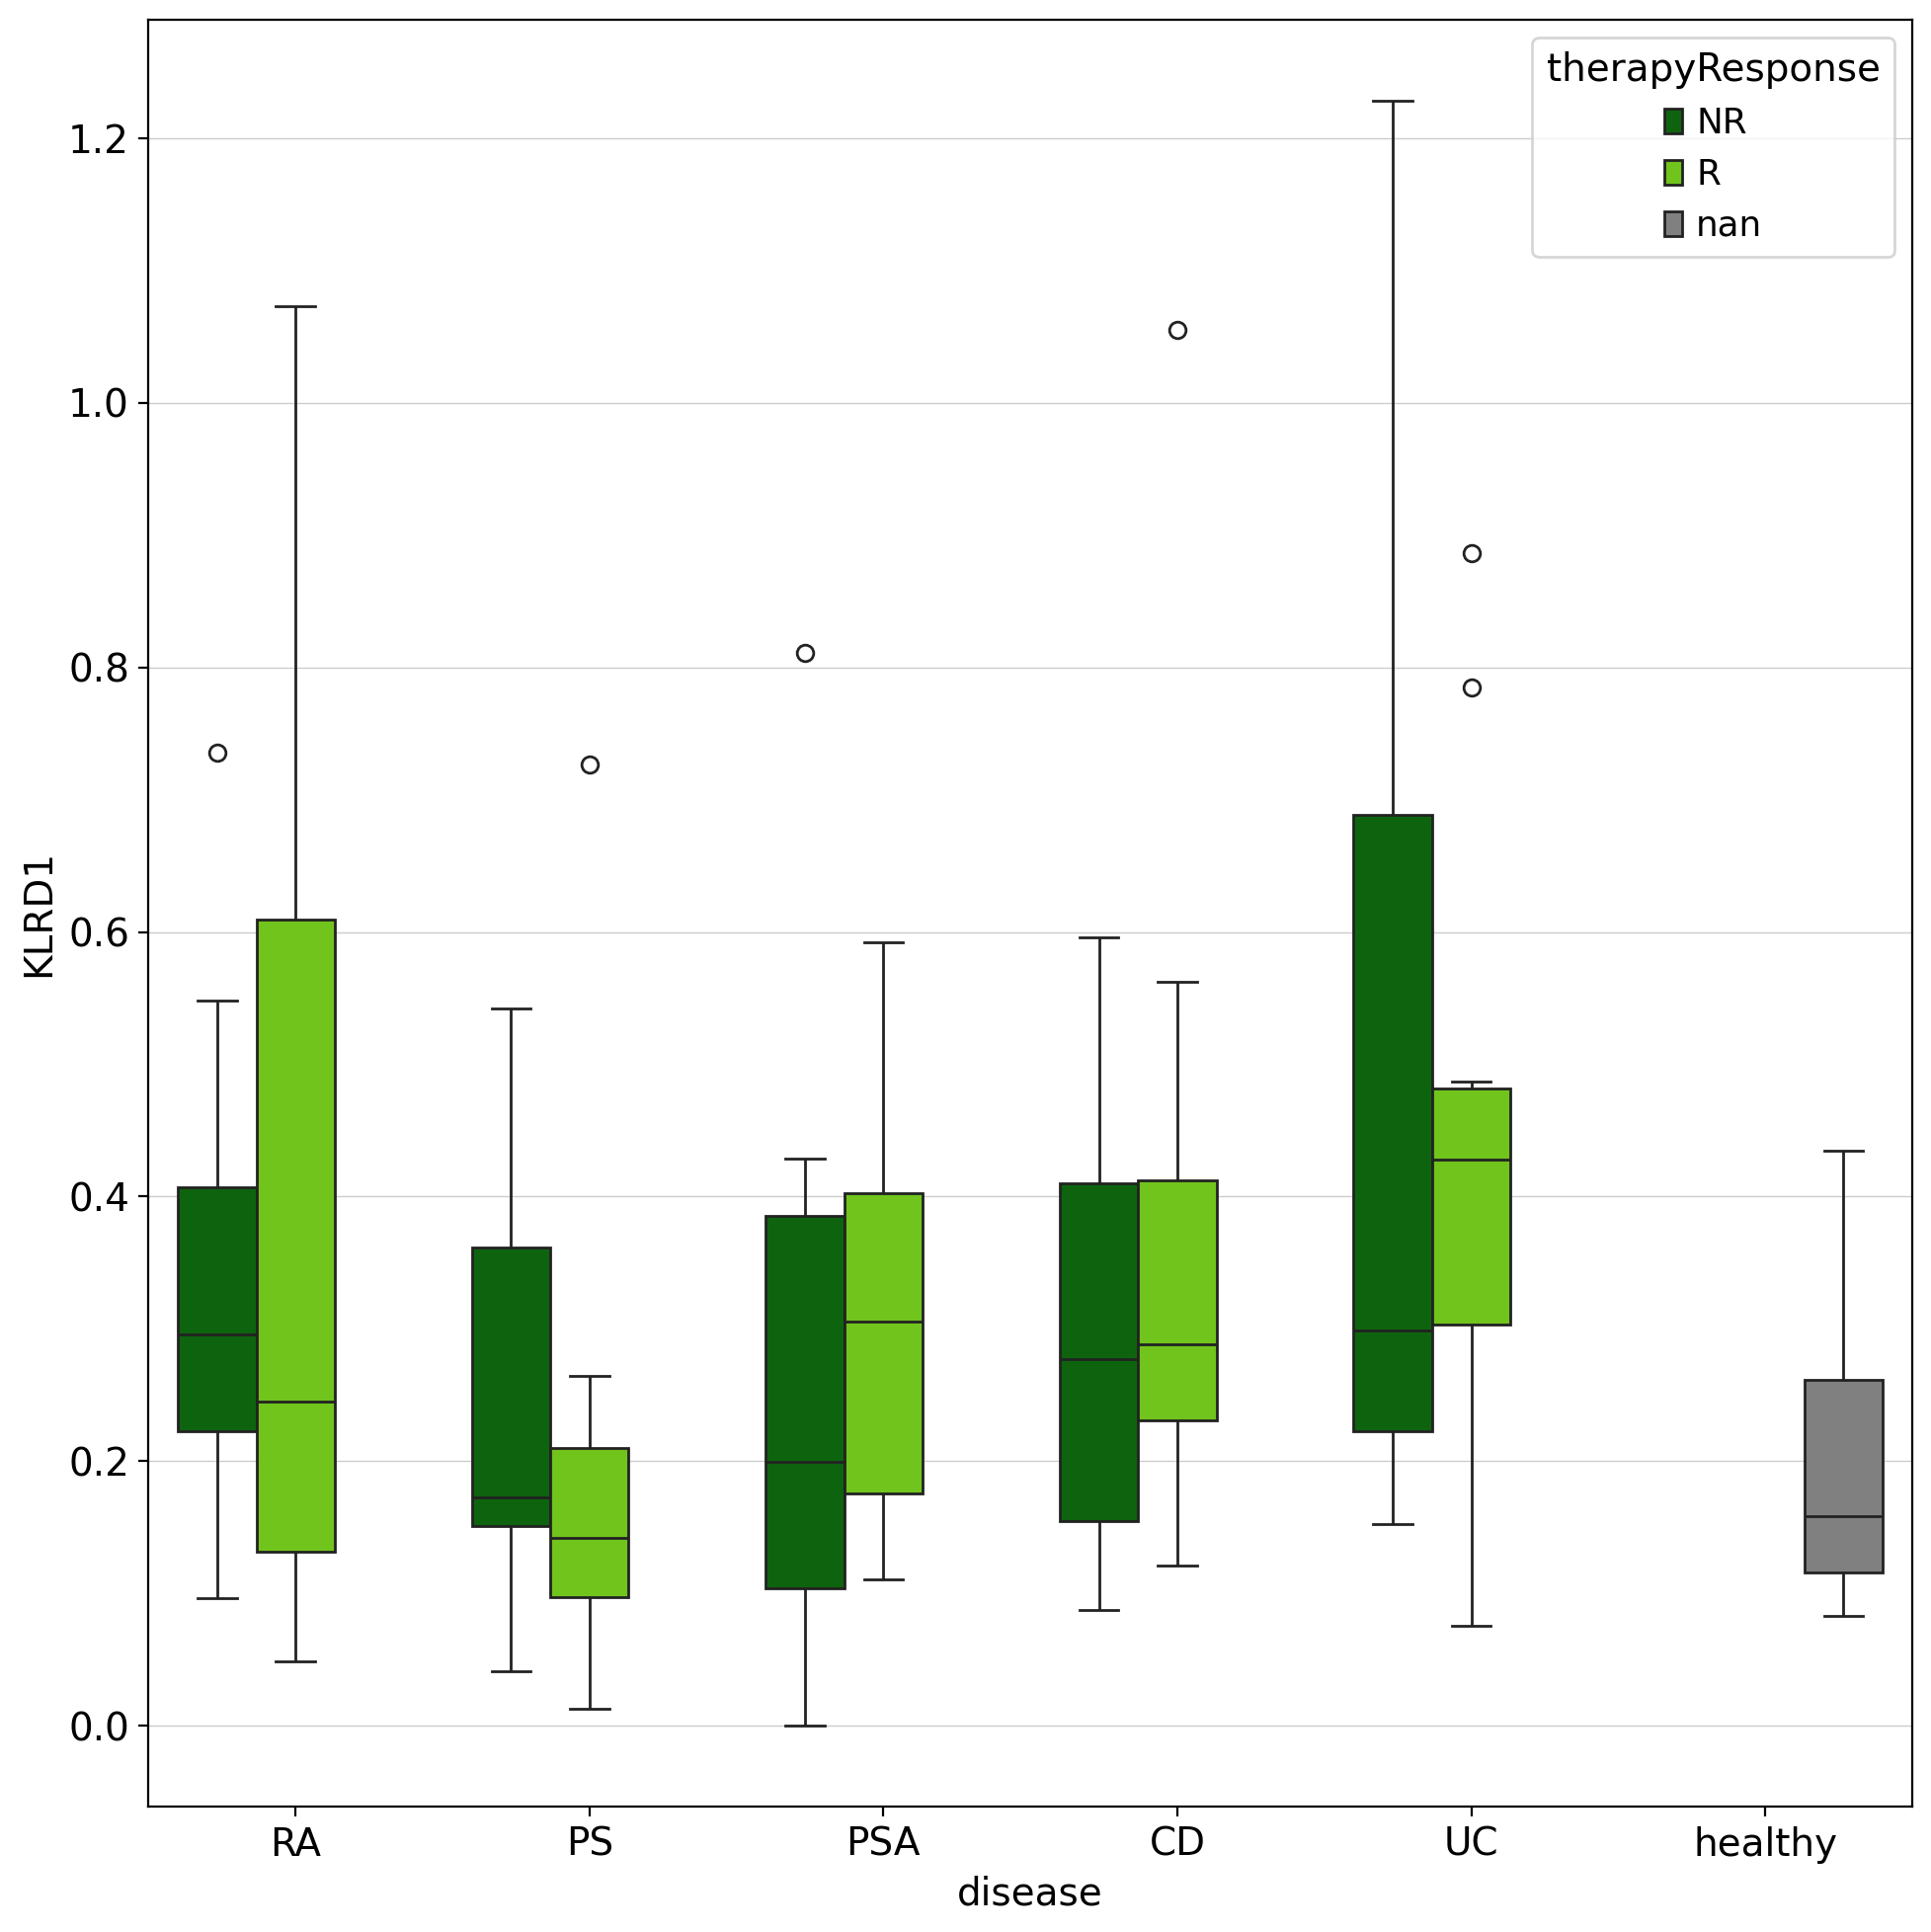

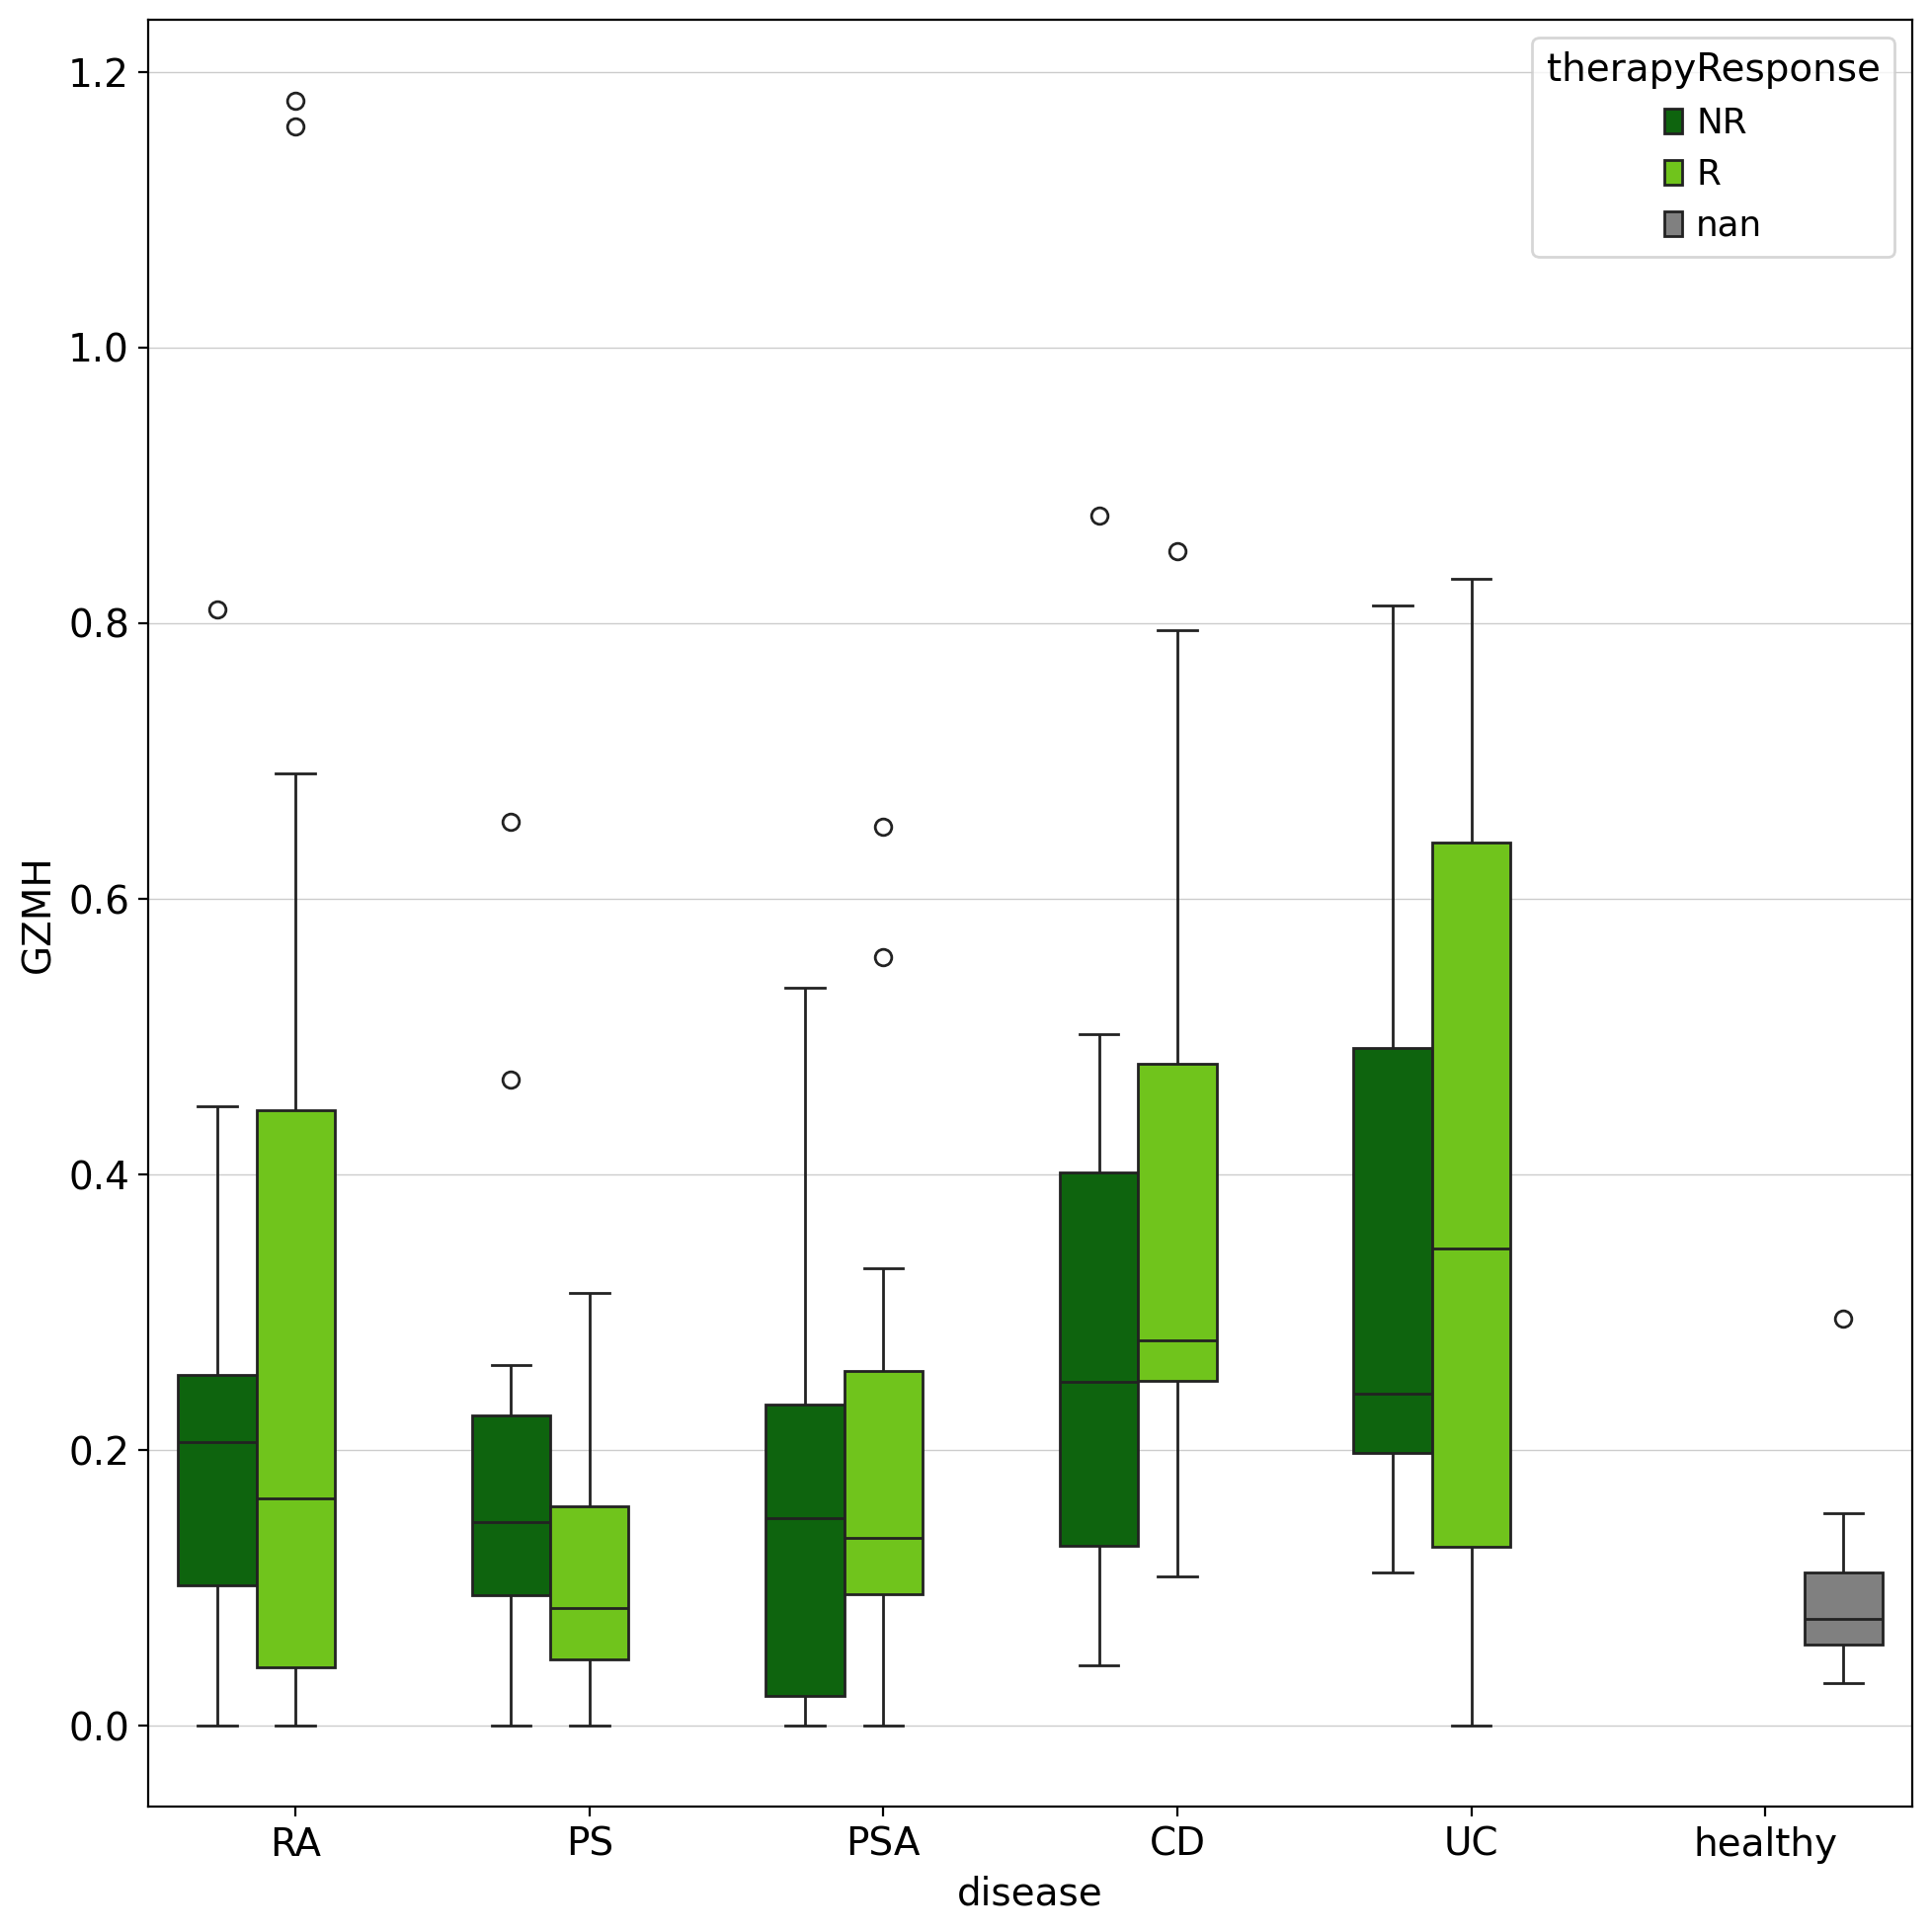

In [236]:
adata_sub =  adata[adata.obs['Level2'] == "T_CD8_CM"]

for gene in genes:
    grouped_data = adata_sub.obs.groupby(['sampleID', 'disease', 'Level2', 'therapyResponse'])[gene].mean().reset_index()
    
    plt.figure(figsize=(10, 10))
    # Facet by disease
    sns.boxplot(x='disease', y=gene, hue='therapyResponse', data=grouped_data, palette=response_palette)
    plt.tight_layout()
    plt.show()

In [18]:
session_info.show()